## Imports

In [1]:
import numpy as np
from jax.config import config; config.update("jax_enable_x64", True)
import jax.numpy as jnp
import networkx as nx
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline

## MAXcut and Weighted MAXcut Hamiltonians

In [2]:
def maxcut(nqubits, norm=2, random_graph=False):
    """Builds maxcut hamiltonian"""
    if random_graph:
        aa = np.random.randint(1, nqubits*(nqubits-1)/2+1)
        graph = nx.random_graphs.dense_gnm_random_graph(nqubits, aa)
        V = nx.adjacency_matrix(graph).toarray()

    ham = jnp.zeros(shape=(2**nqubits,2**nqubits), dtype=np.float64)
    z = jnp.array([[1,0],[0,-1]], dtype=np.float64)
    iden = jnp.array([[1,0],[0,1]], dtype=np.float64)
    for i in range(nqubits):
        for j in range(nqubits):
            h = jnp.eye(1)
            for k in range(nqubits):
                if (k == i) ^ (k == j):
                    h = jnp.kron(h, z)
                else:
                    h = jnp.kron(h, iden)            
            M = jnp.eye(2**nqubits) - h
            if random_graph:
                ham += V[i,j] * M
            else:
                ham += M
    return - 1/norm * ham    


def weighted_maxcut(nqubits, norm=2, random_graph=False):
    """Builds maxcut hamiltonian"""
    weights = jnp.array([[0.5488135 , 0.71518937, 0.60276338, 0.54488318, 0.4236548 ],
                         [0.64589411, 0.43758721, 0.891773  , 0.96366276, 0.38344152],
                         [0.79172504, 0.52889492, 0.56804456, 0.92559664, 0.07103606],
                         [0.0871293 , 0.0202184 , 0.83261985, 0.77815675, 0.87001215],
                         [0.97861834, 0.79915856, 0.46147936, 0.78052918, 0.11827443]], 
                        dtype=np.float64)
    if random_graph:
        aa = np.random.randint(1, nqubits*(nqubits-1)/2+1)
        graph = nx.random_graphs.dense_gnm_random_graph(nqubits, aa)
        V = nx.adjacency_matrix(graph).toarray()

    ham = jnp.zeros(shape=(2**nqubits,2**nqubits), dtype=np.float64)
    z = jnp.array([[1,0],[0,-1]], dtype=np.float64)
    iden = jnp.array([[1,0],[0,1]], dtype=np.float64)
    for i in range(nqubits):
        for j in range(nqubits):
            h = jnp.eye(1)
            for k in range(nqubits):
                if (k == i) ^ (k == j):
                    h = jnp.kron(h, z)
                else:
                    h = jnp.kron(h, iden)            
            M = jnp.eye(2**nqubits) - h
            if random_graph:
                ham += V[i,j] * weights[i,j] * M
            else:
                ham += M * weights[i,j]
    return - 1/norm * ham    

## Optimization class

In [3]:
def Qu(beta, eps=1e-3, deltal=1):
    return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


class FragmentedQuITE:
    
    def __init__(self, nqubits, hamiltonian, query, eps=1e-3):
        """Test function for optimization."""
        self.n = nqubits
        energy = jnp.linalg.eigvalsh(hamiltonian)
        self.E = energy/((np.max(energy)-np.min(energy))/2)
        self.Emin = np.min(self.E)
        self.query = query
        self.eps = eps

    def minimize(self, schedule, r, b, initial_parameters=None, method='BFGS', bounds=None, options=None):
        """Optimizes scheduling function."""
        from scipy.optimize import minimize
        
        # imposes differences to be positive
        def derivative(p):
            points = np.array([schedule(step/r, p) for step in range(1, r+1)])
            return np.diff(points)
                        
        con1 = None
        if method == 'COBYLA':
            con1 = {'type': 'ineq', 'fun': derivative}        
        m = minimize(lambda p, _: self.compute_query(p, schedule, r, b),
                        initial_parameters,
                        method, bounds=bounds, options=options, constraints=con1)
        return m      
        
    def compute_query(self, params, schedule, r, b, query_depth=False):
        """Compute query optimization."""
        beta = np.array([ b * schedule(step/r, params) for step in range(1, r+1)])
        
        # k == 0
        PsucBr = self.Psuc(beta[r-1])
        eps_prime = self.eps / (2 * 4.0**(r-1)) * np.sqrt(PsucBr)
        Sigma = self.query(beta[0]-0, eps=eps_prime, deltal=1)

        # k > 0
        DeltaBeta = np.diff(beta)
        for k in range(r-1):
            PsucBk = 1
            if not query_depth:
                PsucBk = self.Psuc(beta[k])
            eps_prime = self.eps / 4.0**(r-(k+1)) * np.sqrt(PsucBr/PsucBk)
            Sigma += PsucBk * self.query(DeltaBeta[k], eps=eps_prime, deltal=1)
        
        Psbeta = 1
        if not query_depth:
            Psbeta = self.Psuc(beta[r-1])             
        return 1/Psbeta * Sigma

    def Psuc(self, beta):
        Zt =  np.sum(np.exp(-beta * (self.E - self.Emin)))
        N = 2**self.n    
        return Zt / N
    
    def Qfrac_linear(self, r, b):
        """Return linear query prediction."""
        return self.compute_query(params=None, schedule=lambda t, _: t, r=r, b=b)
    
    def Q(self, beta, alpha=1):        
        Psbeta = self.Psuc(beta)
        bquery = self.query(beta=beta**alpha, eps=self.eps / 2 * np.sqrt(Psbeta), deltal=1)
        return 1/Psbeta * bquery
    
    def Qampl(self, beta, alpha=1):
        Psbeta = self.Psuc(beta)                
        return 1/np.sqrt(Psbeta) * self.query(beta=beta**alpha, eps=self.eps / 2 * np.sqrt(Psbeta), deltal=1)

## Example

In [4]:
# setup
np.random.seed(0)
ntrials = 10
nqubits = 5
npol = 1

def myschedule(t, params):
    return t**params[0]


r_range = range(2, 25) 
beta_max = 300
alpha_c = 0.6
alpha_ampl = 0.85
beta_range = range(2, beta_max+1, 10)
qref = np.zeros(shape=(len(beta_range),ntrials))
qref_depth = np.zeros(shape=(len(beta_range),ntrials))
qampl = np.zeros(shape=(len(beta_range),ntrials))
qampl_alpha = np.zeros(shape=(len(beta_range),ntrials))
qc = np.zeros(shape=(len(beta_range),ntrials))
qc_alpha = np.zeros(shape=(len(beta_range),ntrials))
qc_depth = np.zeros(shape=(len(beta_range),ntrials))
bestr = np.zeros(shape=(len(beta_range), ntrials))
bestr_opt = np.zeros(shape=(len(beta_range), ntrials))
qopt = np.zeros(shape=(len(beta_range),ntrials))
qopt_depth = np.zeros(shape=(len(beta_range),ntrials))
parameters = np.zeros(shape=(len(beta_range), ntrials, npol))


for nt in range(ntrials):
    print(f'trial={nt}')
    model = FragmentedQuITE(nqubits, weighted_maxcut(nqubits, norm=40.0, 
                            random_graph=True), Qu)
    
    for ii, beta in enumerate(beta_range):
        qampl[ii][nt] =  model.Qampl(beta)
        qampl_alpha[ii][nt] = model.Qampl(beta, alpha=alpha_ampl)
        qc[ii][nt] = model.Q(beta)
        qc_depth[ii][nt] = model.Psuc(beta)*qc[ii][nt]
        qc_alpha[ii][nt] = model.Q(beta, alpha=alpha_c)
        
        values = []
        for r in r_range:           
            reference = model.Qfrac_linear(r, beta)
            values.append(reference)
            print(f'trial={nt}, beta={beta}, r={r}, reference={reference}')
        
        qref[ii][nt] = np.min(values)
        qref_depth[ii][nt] = model.compute_query(params=None, schedule=lambda t, _: t, 
                                                 r=r_range[np.argmin(values)], b=beta, query_depth=True)
        bestr[ii][nt] = r_range[np.argmin(values)]
        if bestr[ii][nt] == r_range[-1]:
            raise RuntimeError('Increase r_range max value.')
             
        values2 = []
        params2 = []
        for r in r_range:           
            initial_guess = np.array([1.0])
            result = model.minimize(myschedule, initial_parameters=initial_guess, 
                                    r=r, b=beta,
                                    method='L-BFGS-B', bounds=[[1e-3,1e3]])
            if result.success == False:
                print(result)
                continue
            values2.append(result.fun)
            params2.append(result.x)
            print(f'trial={nt}, beta={beta}, r={r}, opt result={result.fun}, param={result.x} success={result.success}')
            
        qopt[ii][nt] = np.min(values2)
        qopt_depth[ii][nt] = model.compute_query(params=params2[np.argmin(values2)], schedule=myschedule,
                                                r=r_range[np.argmin(values2)], b=beta, query_depth=True)
        bestr_opt[ii][nt] = r_range[np.argmin(values2)]
        parameters[ii][nt] = params2[np.argmin(values2)]
        if bestr_opt[ii][nt] == r_range[-1]:
            raise RuntimeError('Increase r_range max value.')

trial=0
trial=0, beta=2, r=2, reference=33.84012915228619
trial=0, beta=2, r=3, reference=39.34576509719949
trial=0, beta=2, r=4, reference=45.96100425552992
trial=0, beta=2, r=5, reference=53.25479989276194
trial=0, beta=2, r=6, reference=61.0948287300977
trial=0, beta=2, r=7, reference=69.42666475029195
trial=0, beta=2, r=8, reference=78.22285527099544
trial=0, beta=2, r=9, reference=87.46716081492697
trial=0, beta=2, r=10, reference=97.14867101906555
trial=0, beta=2, r=11, reference=107.25929487681236
trial=0, beta=2, r=12, reference=117.79257562869647
trial=0, beta=2, r=13, reference=128.74308315839215
trial=0, beta=2, r=14, reference=140.1060799568927
trial=0, beta=2, r=15, reference=151.87732583657595
trial=0, beta=2, r=16, reference=164.05295722394735
trial=0, beta=2, r=17, reference=176.6294086287312
trial=0, beta=2, r=18, reference=189.60335907852607
trial=0, beta=2, r=19, reference=202.97169396277678
trial=0, beta=2, r=20, reference=216.73147676550855
trial=0, beta=2, r=21, r

trial=0, beta=22, r=13, opt result=363.99889164745343, param=[1.03529523] success=True
trial=0, beta=22, r=14, opt result=379.5292663943936, param=[0.99699765] success=True
trial=0, beta=22, r=15, opt result=395.14964444746755, param=[0.96297624] success=True
trial=0, beta=22, r=16, opt result=410.8615429947986, param=[0.93250324] success=True
trial=0, beta=22, r=17, opt result=426.66758820668053, param=[0.90500933] success=True
trial=0, beta=22, r=18, opt result=442.5708719177867, param=[0.88004245] success=True
trial=0, beta=22, r=19, opt result=458.57459807500885, param=[0.85723997] success=True
trial=0, beta=22, r=20, opt result=474.6818925723794, param=[0.83630657] success=True
trial=0, beta=22, r=21, opt result=490.895706053985, param=[0.81699977] success=True
trial=0, beta=22, r=22, opt result=507.21876970957413, param=[0.7991184] success=True
trial=0, beta=22, r=23, opt result=523.6535810478995, param=[0.7824941] success=True
trial=0, beta=22, r=24, opt result=540.2024062696847

trial=0, beta=52, r=4, opt result=296.7473412512737, param=[2.37171222] success=True
trial=0, beta=52, r=5, opt result=305.2453228222418, param=[2.1574933] success=True
trial=0, beta=52, r=6, opt result=317.35120151841244, param=[1.99782267] success=True
trial=0, beta=52, r=7, opt result=331.4621786212451, param=[1.86663496] success=True
trial=0, beta=52, r=8, opt result=410.4426243565763, param=[9.82120151] success=True


<ipython-input-3-dbb673c93788>:2: RuntimeWarning: overflow encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-3-dbb673c93788>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


trial=0, beta=52, r=9, opt result=430.38681790357776, param=[12.60404138] success=True
trial=0, beta=52, r=10, opt result=448.08849866411816, param=[15.53381677] success=True
trial=0, beta=52, r=11, opt result=395.9908825951644, param=[1.51610672] success=True
trial=0, beta=52, r=12, opt result=412.98702222067226, param=[1.45673763] success=True
trial=0, beta=52, r=13, opt result=430.15057218462465, param=[1.4045994] success=True
trial=0, beta=52, r=14, opt result=447.44927537443874, param=[1.35840961] success=True
trial=0, beta=52, r=15, opt result=464.86424897621913, param=[1.31716562] success=True
trial=0, beta=52, r=16, opt result=482.385059666371, param=[1.28007632] success=True
trial=0, beta=52, r=17, opt result=500.0066572447658, param=[1.24651037] success=True
trial=0, beta=52, r=18, opt result=517.7274197222323, param=[1.21595883] success=True
trial=0, beta=52, r=19, opt result=535.5478852090679, param=[1.18800755] success=True
trial=0, beta=52, r=20, opt result=553.4699196835

trial=0, beta=82, r=5, opt result=356.28061479394336, param=[2.3651435] success=True
trial=0, beta=82, r=6, opt result=455.28345275365945, param=[14.21358234] success=True
trial=0, beta=82, r=7, opt result=467.2552427842858, param=[16.6653263] success=True
trial=0, beta=82, r=8, opt result=478.94175596123966, param=[19.32117983] success=True
trial=0, beta=82, r=9, opt result=473.67807374242295, param=[13.21811791] success=True
trial=0, beta=82, r=10, opt result=491.0293365929311, param=[15.54863416] success=True
trial=0, beta=82, r=11, opt result=507.1742009600605, param=[17.96831216] success=True
trial=0, beta=82, r=12, opt result=522.2305469695359, param=[20.55423121] success=True
trial=0, beta=82, r=13, opt result=536.2469523814558, param=[23.47730019] success=True
trial=0, beta=82, r=14, opt result=541.3201395288669, param=[36.56450163] success=True
trial=0, beta=82, r=15, opt result=550.5991735821137, param=[39.51222719] success=True
trial=0, beta=82, r=16, opt result=559.63360475

trial=0, beta=112, r=4, opt result=486.56497231599957, param=[10.27367666] success=True
trial=0, beta=112, r=5, opt result=422.69755015878576, param=[3.89487844] success=True
trial=0, beta=112, r=6, opt result=415.7173048227593, param=[2.33287133] success=True
trial=0, beta=112, r=7, opt result=521.5342882761217, param=[18.62853807] success=True
trial=0, beta=112, r=8, opt result=532.2384389269386, param=[21.47102199] success=True
trial=0, beta=112, r=9, opt result=542.5861166647279, param=[24.36648008] success=True
trial=0, beta=112, r=10, opt result=533.5062588158173, param=[16.18562223] success=True
trial=0, beta=112, r=11, opt result=549.1864880196503, param=[18.47756809] success=True
trial=0, beta=112, r=12, opt result=564.0136419538965, param=[20.83536528] success=True
trial=0, beta=112, r=13, opt result=578.072841153585, param=[23.27579956] success=True
trial=0, beta=112, r=14, opt result=591.4322213406783, param=[25.82269114] success=True
trial=0, beta=112, r=15, opt result=604

trial=0, beta=142, r=4, opt result=539.5161900187636, param=[10.90831798] success=True
trial=0, beta=142, r=5, opt result=490.761205377143, param=[6.97003539] success=True
trial=0, beta=142, r=6, opt result=461.81662036383335, param=[2.4302717] success=True
trial=0, beta=142, r=7, opt result=475.89742208022244, param=[2.2971806] success=True
trial=0, beta=142, r=8, opt result=583.2882228806709, param=[22.94945009] success=True
trial=0, beta=142, r=9, opt result=593.0433707564276, param=[26.00938091] success=True
trial=0, beta=142, r=10, opt result=602.4698001525608, param=[29.10003202] success=True
trial=0, beta=142, r=11, opt result=591.1706835350399, param=[19.06332445] success=True
trial=0, beta=142, r=12, opt result=605.6332185604767, param=[21.37461106] success=True
trial=0, beta=142, r=13, opt result=619.4341214379674, param=[23.73738395] success=True
trial=0, beta=142, r=14, opt result=632.6379634703064, param=[26.1570617] success=True
trial=0, beta=142, r=15, opt result=645.300

trial=0, beta=162, r=24, opt result=741.7048368803562, param=[76.40268725] success=True
trial=0, beta=172, r=2, reference=2155.959208356426
trial=0, beta=172, r=3, reference=1598.3982723711672
trial=0, beta=172, r=4, reference=1332.664965808875
trial=0, beta=172, r=5, reference=1183.315061882723
trial=0, beta=172, r=6, reference=1091.83824497804
trial=0, beta=172, r=7, reference=1033.1611402104675
trial=0, beta=172, r=8, reference=994.7652925410941
trial=0, beta=172, r=9, reference=969.7203344423343
trial=0, beta=172, r=10, reference=953.8933460151115
trial=0, beta=172, r=11, reference=944.6780749389643
trial=0, beta=172, r=12, reference=940.3581950441737
trial=0, beta=172, r=13, reference=939.7636715902488
trial=0, beta=172, r=14, reference=942.0739933969832
trial=0, beta=172, r=15, reference=946.6999472540814
trial=0, beta=172, r=16, reference=953.2097137077913
trial=0, beta=172, r=17, reference=961.2811218318843
trial=0, beta=172, r=18, reference=970.6699386587062
trial=0, beta=172,

trial=0, beta=192, r=8, opt result=615.727104983872, param=[13.30364872] success=True
trial=0, beta=192, r=9, opt result=674.3148417207855, param=[28.04340709] success=True
trial=0, beta=192, r=10, opt result=683.1176819404984, param=[31.34753933] success=True
trial=0, beta=192, r=11, opt result=691.6346612030601, param=[34.66971485] success=True
trial=0, beta=192, r=12, opt result=699.8963952839903, param=[38.00937734] success=True
trial=0, beta=192, r=13, opt result=688.3874924776208, param=[24.60513407] success=True
trial=0, beta=192, r=14, opt result=701.2141425818575, param=[26.98552639] success=True
trial=0, beta=192, r=15, opt result=713.5807553666981, param=[29.40319531] success=True
trial=0, beta=192, r=16, opt result=725.5296990336446, param=[31.85944656] success=True
trial=0, beta=192, r=17, opt result=737.0978127045786, param=[34.35634647] success=True
trial=0, beta=192, r=18, opt result=748.3167275043606, param=[36.89686989] success=True
trial=0, beta=192, r=19, opt result

trial=0, beta=222, r=4, opt result=672.0913224703988, param=[12.07615379] success=True
trial=0, beta=222, r=5, opt result=569.6973628572168, param=[2.81548962] success=True
trial=0, beta=222, r=6, opt result=627.4336048117107, param=[9.71560908] success=True
trial=0, beta=222, r=7, opt result=643.2336944188473, param=[11.67024406] success=True
trial=0, beta=222, r=8, opt result=658.9437860552702, param=[13.74510197] success=True
trial=0, beta=222, r=9, opt result=721.8708659353333, param=[29.00744766] success=True
trial=0, beta=222, r=10, opt result=730.4105584078238, param=[32.41883883] success=True
trial=0, beta=222, r=11, opt result=738.6684052235967, param=[35.8447084] success=True
trial=0, beta=222, r=12, opt result=746.6768186646534, param=[39.2849091] success=True
trial=0, beta=222, r=13, opt result=729.8042580056281, param=[25.09707046] success=True
trial=0, beta=222, r=14, opt result=742.4107173234341, param=[27.48003154] success=True
trial=0, beta=222, r=15, opt result=754.58

trial=0, beta=242, r=24, opt result=876.8257727435696, param=[53.33587113] success=True
trial=0, beta=252, r=2, reference=3081.8266786785734
trial=0, beta=252, r=3, reference=2253.903272508994
trial=0, beta=252, r=4, reference=1854.164496666902
trial=0, beta=252, r=5, reference=1625.5992471793484
trial=0, beta=252, r=6, reference=1482.4755740465655
trial=0, beta=252, r=7, reference=1388.0172443106112
trial=0, beta=252, r=8, reference=1323.8211317828914
trial=0, beta=252, r=9, reference=1279.6607327469355
trial=0, beta=252, r=10, reference=1249.4052025291912
trial=0, beta=252, r=11, reference=1229.1622954694158
trial=0, beta=252, r=12, reference=1216.3482182185116
trial=0, beta=252, r=13, reference=1209.1856191227714
trial=0, beta=252, r=14, reference=1206.4159360723115
trial=0, beta=252, r=15, reference=1207.126296168682
trial=0, beta=252, r=16, reference=1210.6410178931246
trial=0, beta=252, r=17, reference=1216.4512327722482
trial=0, beta=252, r=18, reference=1224.1678830163714
trial

trial=0, beta=272, r=7, opt result=715.5550344833412, param=[12.23593492] success=True
trial=0, beta=272, r=8, opt result=791.1717963511732, param=[26.79072219] success=True
trial=0, beta=272, r=9, opt result=799.6998711495805, param=[30.34449017] success=True
trial=0, beta=272, r=10, opt result=807.9048346500703, param=[33.90817918] success=True
trial=0, beta=272, r=11, opt result=815.8318193539133, param=[37.48258942] success=True
trial=0, beta=272, r=12, opt result=823.515469291041, param=[41.06791654] success=True
trial=0, beta=272, r=13, opt result=798.8750153429987, param=[25.84741698] success=True
trial=0, beta=272, r=14, opt result=811.1481845625533, param=[28.24809788] success=True
trial=0, beta=272, r=15, opt result=823.0302708069619, param=[30.67508943] success=True
trial=0, beta=272, r=16, opt result=834.5559005585362, param=[33.12750723] success=True
trial=0, beta=272, r=17, opt result=845.7564162930244, param=[35.60481903] success=True
trial=0, beta=272, r=18, opt result=

trial=1, beta=2, r=21, reference=121.85006711470463
trial=1, beta=2, r=22, reference=129.48077349896374
trial=1, beta=2, r=23, reference=137.3086118974914
trial=1, beta=2, r=24, reference=145.33245103822966
trial=1, beta=2, r=2, opt result=16.388922992367576, param=[1.5182403] success=True
trial=1, beta=2, r=3, opt result=19.905630823452096, param=[1.02337347] success=True
trial=1, beta=2, r=4, opt result=20.628167047697918, param=[0.001] success=True
trial=1, beta=2, r=5, opt result=22.834015459743046, param=[0.001] success=True
trial=1, beta=2, r=6, opt result=25.11490840296442, param=[0.001] success=True
trial=1, beta=2, r=7, opt result=27.475685651321875, param=[0.001] success=True
trial=1, beta=2, r=8, opt result=29.919665867000173, param=[0.001] success=True
trial=1, beta=2, r=9, opt result=32.44919510228497, param=[0.001] success=True
trial=1, beta=2, r=10, opt result=35.06596308973532, param=[0.001] success=True
trial=1, beta=2, r=11, opt result=37.77119953126034, param=[0.001]

trial=1, beta=22, r=23, opt result=78.45700144988808, param=[72.11144746] success=True
trial=1, beta=22, r=24, opt result=79.27314028734409, param=[75.72177167] success=True
trial=1, beta=32, r=2, reference=88.85087964197865
trial=1, beta=32, r=3, reference=90.1728198754965
trial=1, beta=32, r=4, reference=94.97922856771902
trial=1, beta=32, r=5, reference=101.11368987498837
trial=1, beta=32, r=6, reference=107.88718872063163
trial=1, beta=32, r=7, reference=115.02960381691068
trial=1, beta=32, r=8, reference=122.42450390677112
trial=1, beta=32, r=9, reference=130.02018113571378
trial=1, beta=32, r=10, reference=137.7943257796088
trial=1, beta=32, r=11, reference=145.738445785438
trial=1, beta=32, r=12, reference=153.85054129668524
trial=1, beta=32, r=13, reference=162.1315372735555
trial=1, beta=32, r=14, reference=170.58352392966984
trial=1, beta=32, r=15, reference=179.20889654117937
trial=1, beta=32, r=16, reference=188.00995062952913
trial=1, beta=32, r=17, reference=196.988708616

trial=1, beta=52, r=10, opt result=106.80498700681818, param=[32.41789542] success=True
trial=1, beta=52, r=11, opt result=107.85236733437682, param=[35.95920876] success=True
trial=1, beta=52, r=12, opt result=108.85444128498501, param=[39.51705272] success=True
trial=1, beta=52, r=13, opt result=109.81827489888036, param=[43.09068242] success=True
trial=1, beta=52, r=14, opt result=110.74936882350723, param=[46.67924806] success=True
trial=1, beta=52, r=15, opt result=111.65209277458155, param=[50.28222904] success=True
trial=1, beta=52, r=16, opt result=112.52997779694634, param=[53.89918807] success=True
trial=1, beta=52, r=17, opt result=113.38591922193336, param=[57.52943043] success=True
trial=1, beta=52, r=18, opt result=114.22232139994057, param=[61.17271441] success=True
trial=1, beta=52, r=19, opt result=115.0412032818821, param=[64.82855587] success=True
trial=1, beta=52, r=20, opt result=115.8442769621349, param=[68.49664591] success=True
trial=1, beta=52, r=21, opt result

trial=1, beta=82, r=4, opt result=139.9211929695515, param=[12.73265389] success=True
trial=1, beta=82, r=5, opt result=141.57746710038995, param=[16.46463999] success=True
trial=1, beta=82, r=6, opt result=143.00436169453207, param=[20.20798171] success=True
trial=1, beta=82, r=7, opt result=144.28225466482027, param=[23.96518038] success=True
trial=1, beta=82, r=8, opt result=145.45374482996885, param=[27.73638838] success=True
trial=1, beta=82, r=9, opt result=146.54479071782356, param=[31.52113377] success=True
trial=1, beta=82, r=10, opt result=147.57261354247214, param=[35.31875619] success=True
trial=1, beta=82, r=11, opt result=148.5493118804617, param=[39.12866878] success=True
trial=1, beta=82, r=12, opt result=149.4837470712388, param=[42.95022379] success=True
trial=1, beta=82, r=13, opt result=150.38262021701783, param=[46.78297899] success=True
trial=1, beta=82, r=14, opt result=151.2511296437634, param=[50.62640094] success=True
trial=1, beta=82, r=15, opt result=152.093

trial=1, beta=112, r=8, reference=269.8203333827404
trial=1, beta=112, r=9, reference=280.8252983608194
trial=1, beta=112, r=10, reference=292.39618449613306
trial=1, beta=112, r=11, reference=304.3935175737942
trial=1, beta=112, r=12, reference=316.7246247939136
trial=1, beta=112, r=13, reference=329.3268845630361
trial=1, beta=112, r=14, reference=342.1576574837648
trial=1, beta=112, r=15, reference=355.18792044678975
trial=1, beta=112, r=16, reference=368.3980848395621
trial=1, beta=112, r=17, reference=381.77516958484154
trial=1, beta=112, r=18, reference=395.3108489830913
trial=1, beta=112, r=19, reference=409.00008340655154
trial=1, beta=112, r=20, reference=422.8401478604805
trial=1, beta=112, r=21, reference=436.8299372498001
trial=1, beta=112, r=22, reference=450.96946686401714
trial=1, beta=112, r=23, reference=465.25951211779807
trial=1, beta=112, r=24, reference=479.7013484746266
trial=1, beta=112, r=2, opt result=175.76931776036415, param=[5.55710955] success=True
trial=1,

trial=1, beta=132, r=13, opt result=218.1231434973717, param=[50.98625745] success=True
trial=1, beta=132, r=14, opt result=218.9295182045528, param=[55.13835223] success=True
trial=1, beta=132, r=15, opt result=219.71144104132213, param=[59.29784975] success=True
trial=1, beta=132, r=16, opt result=220.47205151508544, param=[63.46447336] success=True
trial=1, beta=132, r=17, opt result=221.21391308178488, param=[67.63801248] success=True
trial=1, beta=132, r=18, opt result=221.9391467212215, param=[71.81832479] success=True
trial=1, beta=132, r=19, opt result=222.6495277117668, param=[76.00517022] success=True
trial=1, beta=132, r=20, opt result=223.3465571992496, param=[80.19839523] success=True
trial=1, beta=132, r=21, opt result=224.03151608502537, param=[84.39776978] success=True
trial=1, beta=132, r=22, opt result=224.70550624951508, param=[88.60318781] success=True
trial=1, beta=132, r=23, opt result=225.3694825295268, param=[92.81476434] success=True
trial=1, beta=132, r=24, op

trial=1, beta=162, r=5, opt result=250.8436144030124, param=[18.77028756] success=True
trial=1, beta=162, r=6, opt result=252.1463290535256, param=[23.0094366] success=True
trial=1, beta=162, r=7, opt result=253.30722726179638, param=[27.25439349] success=True
trial=1, beta=162, r=8, opt result=254.36795152001605, param=[31.50641676] success=True
trial=1, beta=162, r=9, opt result=264.4702155980642, param=[21.1695465] success=True
trial=1, beta=162, r=10, opt result=256.28070375343026, param=[40.03268766] success=True
trial=1, beta=162, r=11, opt result=257.1607115586945, param=[44.30677246] success=True
trial=1, beta=162, r=12, opt result=258.001989792965, param=[48.58787436] success=True
trial=1, beta=162, r=13, opt result=258.8108180234925, param=[52.87585575] success=True
trial=1, beta=162, r=14, opt result=259.59204334953245, param=[57.1704546] success=True
trial=1, beta=162, r=15, opt result=260.3494891956771, param=[61.47140389] success=True
trial=1, beta=162, r=16, opt result=2

trial=1, beta=192, r=3, opt result=288.34742614563703, param=[10.61437769] success=True
trial=1, beta=192, r=4, opt result=290.2477059537173, param=[14.99500313] success=True
trial=1, beta=192, r=5, opt result=298.5802258923116, param=[9.80510061] success=True
trial=1, beta=192, r=6, opt result=293.0153145940484, param=[23.73200161] success=True
trial=1, beta=192, r=7, opt result=294.1497099113832, param=[28.10514119] success=True
trial=1, beta=192, r=8, opt result=295.1853234212587, param=[32.48414615] success=True
trial=1, beta=192, r=9, opt result=296.14704687632513, param=[36.86950224] success=True
trial=1, beta=192, r=10, opt result=306.8284582644637, param=[24.37103541] success=True
trial=1, beta=192, r=11, opt result=308.11111349878485, param=[27.94911333] success=True
trial=1, beta=192, r=12, opt result=298.72909735394467, param=[50.06374525] success=True
trial=1, beta=192, r=13, opt result=299.5172678148293, param=[54.47416419] success=True
trial=1, beta=192, r=14, opt result=

trial=1, beta=212, r=23, opt result=333.39527224223303, param=[100.53055988] success=True
trial=1, beta=212, r=24, opt result=334.0035267959497, param=[105.0673396] success=True
trial=1, beta=222, r=2, reference=478.98183646473734
trial=1, beta=222, r=3, reference=440.35996240561826
trial=1, beta=222, r=4, reference=427.8058779281717
trial=1, beta=222, r=5, reference=426.135482438759
trial=1, beta=222, r=6, reference=430.2254755176878
trial=1, beta=222, r=7, reference=437.8315907400824
trial=1, beta=222, r=8, reference=447.79418296221684
trial=1, beta=222, r=9, reference=459.44052797945926
trial=1, beta=222, r=10, reference=472.34578405135085
trial=1, beta=222, r=11, reference=486.22413992125513
trial=1, beta=222, r=12, reference=500.87406593199336
trial=1, beta=222, r=13, reference=516.1484650547077
trial=1, beta=222, r=14, reference=531.937251336777
trial=1, beta=222, r=15, reference=548.1565638077321
trial=1, beta=222, r=16, reference=564.7417368746846
trial=1, beta=222, r=17, refer

trial=1, beta=242, r=8, opt result=363.20092290662166, param=[33.83544618] success=True
trial=1, beta=242, r=9, opt result=364.1315025553346, param=[38.39600354] success=True
trial=1, beta=242, r=10, opt result=365.00581045688534, param=[42.96181753] success=True
trial=1, beta=242, r=11, opt result=376.30300883197503, param=[27.70579778] success=True
trial=1, beta=242, r=12, opt result=377.5354291825405, param=[30.916151] success=True
trial=1, beta=242, r=13, opt result=378.70336308445866, param=[34.34088706] success=True
trial=1, beta=242, r=14, opt result=368.1234319322557, param=[61.277529] success=True
trial=1, beta=242, r=15, opt result=368.8358176517353, param=[65.86905] success=True
trial=1, beta=242, r=16, opt result=369.52855926764414, param=[70.46548723] success=True
trial=1, beta=242, r=17, opt result=370.2040581524112, param=[75.06637913] success=True
trial=1, beta=242, r=18, opt result=370.86429663517805, param=[79.67194663] success=True
trial=1, beta=242, r=19, opt result

trial=1, beta=272, r=14, reference=612.4627755271017
trial=1, beta=272, r=15, reference=629.5523747221267
trial=1, beta=272, r=16, reference=647.1082160854943
trial=1, beta=272, r=17, reference=665.0656208813429
trial=1, beta=272, r=18, reference=683.3728475541074
trial=1, beta=272, r=19, reference=701.9883056126051
trial=1, beta=272, r=20, reference=720.8784789398486
trial=1, beta=272, r=21, reference=740.0163399913826
trial=1, beta=272, r=22, reference=759.3801148527825
trial=1, beta=272, r=23, reference=778.9523063989336
trial=1, beta=272, r=24, reference=798.7189121120585
trial=1, beta=272, r=2, opt result=394.45835410364174, param=[6.57647974] success=True
trial=1, beta=272, r=3, opt result=397.4520997284181, param=[11.29874899] success=True
trial=1, beta=272, r=4, opt result=399.2817096229555, param=[15.9558027] success=True
trial=1, beta=272, r=5, opt result=407.74800137700277, param=[10.2896035] success=True
trial=1, beta=272, r=6, opt result=409.69011721904496, param=[13.12277

trial=1, beta=292, r=16, opt result=450.0402907952375, param=[44.67179171] success=True
trial=1, beta=292, r=17, opt result=438.019020962883, param=[77.45794222] success=True
trial=1, beta=292, r=18, opt result=438.66073857929894, param=[82.20284951] success=True
trial=1, beta=292, r=19, opt result=439.2891881362874, param=[86.95182355] success=True
trial=1, beta=292, r=20, opt result=439.9057385248981, param=[91.70462977] success=True
trial=1, beta=292, r=21, opt result=440.5115552804419, param=[96.46152594] success=True
trial=1, beta=292, r=22, opt result=441.1076390645846, param=[101.22202041] success=True
trial=1, beta=292, r=23, opt result=441.69485543231565, param=[105.98607325] success=True
trial=1, beta=292, r=24, opt result=442.27395815958783, param=[110.75381528] success=True
trial=2
trial=2, beta=2, r=2, reference=26.433744049325075
trial=2, beta=2, r=3, reference=31.142102559400602
trial=2, beta=2, r=4, reference=36.625296501110626
trial=2, beta=2, r=5, reference=42.6045482

trial=2, beta=22, r=4, opt result=143.00489830962613, param=[1.97752239] success=True
trial=2, beta=22, r=5, opt result=151.8852496888064, param=[1.76964282] success=True
trial=2, beta=22, r=6, opt result=161.99492465934958, param=[1.60394813] success=True
trial=2, beta=22, r=7, opt result=172.6761083080379, param=[1.47057699] success=True
trial=2, beta=22, r=8, opt result=183.65515822227752, param=[1.36236724] success=True
trial=2, beta=22, r=9, opt result=194.81301020687184, param=[1.27337491] success=True
trial=2, beta=22, r=10, opt result=206.09797127200753, param=[1.19905112] success=True
trial=2, beta=22, r=11, opt result=217.48916014216337, param=[1.13604136] success=True
trial=2, beta=22, r=12, opt result=228.9801222268914, param=[1.08188815] success=True
trial=2, beta=22, r=13, opt result=240.5711169284383, param=[1.03477514] success=True
trial=2, beta=22, r=14, opt result=252.2653690840883, param=[0.99334298] success=True
trial=2, beta=22, r=15, opt result=264.0672205621919, 

trial=2, beta=52, r=14, reference=339.29246356853383
trial=2, beta=52, r=15, reference=350.00783083801156
trial=2, beta=52, r=16, reference=361.2114911576807
trial=2, beta=52, r=17, reference=372.86227191158173
trial=2, beta=52, r=18, reference=384.9282927934334
trial=2, beta=52, r=19, reference=397.3843978134947
trial=2, beta=52, r=20, reference=410.21039623770605
trial=2, beta=52, r=21, reference=423.3898308331877
trial=2, beta=52, r=22, reference=436.9090980679292
trial=2, beta=52, r=23, reference=450.75680831990854
trial=2, beta=52, r=24, reference=464.9233129791916
trial=2, beta=52, r=2, opt result=203.39787704854908, param=[3.46885428] success=True
trial=2, beta=52, r=3, opt result=217.41636257049194, param=[5.45555881] success=True
trial=2, beta=52, r=4, opt result=195.20808277819842, param=[2.4501756] success=True
trial=2, beta=52, r=5, opt result=203.55280522498197, param=[2.23677527] success=True
trial=2, beta=52, r=6, opt result=214.11185228792797, param=[2.07373416] success

trial=2, beta=72, r=18, opt result=336.89840727406516, param=[43.8395403] success=True
trial=2, beta=72, r=19, opt result=341.4704326838858, param=[46.78313017] success=True
trial=2, beta=72, r=20, opt result=345.935130206339, param=[49.73293241] success=True
trial=2, beta=72, r=21, opt result=350.3026480827094, param=[52.69072728] success=True
trial=2, beta=72, r=22, opt result=354.5816581731506, param=[55.65763988] success=True
trial=2, beta=72, r=23, opt result=358.7796512199544, param=[58.63439847] success=True
trial=2, beta=72, r=24, opt result=362.9031544367926, param=[61.62139415] success=True
trial=2, beta=82, r=2, reference=584.7808308976804
trial=2, beta=82, r=3, reference=470.5299078698546
trial=2, beta=82, r=4, reference=420.96067022121485
trial=2, beta=82, r=5, reference=397.06399555850555
trial=2, beta=82, r=6, reference=385.88062700489746
trial=2, beta=82, r=7, reference=381.8948841051877
trial=2, beta=82, r=8, reference=382.3770180696646
trial=2, beta=82, r=9, reference

trial=2, beta=102, r=5, opt result=286.2313823094662, param=[4.09889769] success=True
trial=2, beta=102, r=6, opt result=291.2547068008115, param=[2.3931551] success=True
trial=2, beta=102, r=7, opt result=310.7760821663483, param=[7.23767289] success=True
trial=2, beta=102, r=8, opt result=321.39907883203955, param=[12.06392258] success=True
trial=2, beta=102, r=9, opt result=329.80359067594975, param=[14.8924469] success=True
trial=2, beta=102, r=10, opt result=337.42509329793063, param=[17.73557511] success=True
trial=2, beta=102, r=11, opt result=344.3714917952492, param=[20.86638262] success=True
trial=2, beta=102, r=12, opt result=350.6347589477414, param=[25.15873019] success=True
trial=2, beta=102, r=13, opt result=355.93658453766864, param=[30.92642479] success=True
trial=2, beta=102, r=14, opt result=360.9053987415298, param=[34.24234573] success=True
trial=2, beta=102, r=15, opt result=365.69589781434786, param=[37.37487466] success=True
trial=2, beta=102, r=16, opt result=3

trial=2, beta=132, r=16, reference=581.8065961027843
trial=2, beta=132, r=17, reference=593.9953421799091
trial=2, beta=132, r=18, reference=606.7588926534738
trial=2, beta=132, r=19, reference=620.0314452309484
trial=2, beta=132, r=20, reference=633.7619182525625
trial=2, beta=132, r=21, reference=647.9101998706973
trial=2, beta=132, r=22, reference=662.4444554267711
trial=2, beta=132, r=23, reference=677.33916625598
trial=2, beta=132, r=24, reference=692.5736825747542
trial=2, beta=132, r=2, opt result=335.64485528290254, param=[4.31381633] success=True
trial=2, beta=132, r=3, opt result=351.05176469151274, param=[7.29607384] success=True
trial=2, beta=132, r=4, opt result=329.79939435208644, param=[5.1540488] success=True
trial=2, beta=132, r=5, opt result=361.39950935280876, param=[12.32593578] success=True
trial=2, beta=132, r=6, opt result=338.9728444697068, param=[3.80586918] success=True
trial=2, beta=132, r=7, opt result=353.4306043145099, param=[7.61554874] success=True
trial

trial=2, beta=152, r=18, opt result=450.5298275667508, param=[50.92222118] success=True
trial=2, beta=152, r=19, opt result=454.45729197939374, param=[54.08853767] success=True
trial=2, beta=152, r=20, opt result=458.314457459276, param=[57.26452746] success=True
trial=2, beta=152, r=21, opt result=462.10642546974464, param=[60.45034852] success=True
trial=2, beta=152, r=22, opt result=465.83783845781113, param=[63.64579952] success=True
trial=2, beta=152, r=23, opt result=469.5129114948446, param=[66.85070514] success=True
trial=2, beta=152, r=24, opt result=473.13546880853386, param=[70.06483925] success=True
trial=2, beta=162, r=2, reference=1076.5430973020566
trial=2, beta=162, r=3, reference=837.6418825767539
trial=2, beta=162, r=4, reference=727.4346205398507
trial=2, beta=162, r=5, reference=668.7448081698963
trial=2, beta=162, r=6, reference=635.7985083507826
trial=2, beta=162, r=7, reference=617.5261674329416
trial=2, beta=162, r=8, reference=608.3853688185992
trial=2, beta=16

trial=2, beta=182, r=4, opt result=391.4831248748126, param=[3.04804474] success=True
trial=2, beta=182, r=5, opt result=438.08891404936423, param=[13.78069076] success=True
trial=2, beta=182, r=6, opt result=442.63217183422313, param=[16.62086533] success=True
trial=2, beta=182, r=7, opt result=447.16325857644745, param=[19.43880951] success=True
trial=2, beta=182, r=8, opt result=434.2225234955499, param=[10.56388663] success=True
trial=2, beta=182, r=9, opt result=442.96006246504544, param=[14.66885425] success=True
trial=2, beta=182, r=10, opt result=450.6524748858263, param=[17.44609423] success=True
trial=2, beta=182, r=11, opt result=457.82453975977666, param=[20.10723506] success=True
trial=2, beta=182, r=12, opt result=469.31319078224055, param=[34.22805509] success=True
trial=2, beta=182, r=13, opt result=473.527670181908, param=[37.34501577] success=True
trial=2, beta=182, r=14, opt result=477.6563261650176, param=[40.49129923] success=True
trial=2, beta=182, r=15, opt resul

trial=2, beta=202, r=24, opt result=543.0339064737765, param=[74.57227892] success=True
trial=2, beta=212, r=2, reference=1382.9816154092186
trial=2, beta=212, r=3, reference=1065.401706637753
trial=2, beta=212, r=4, reference=916.3659780698162
trial=2, beta=212, r=5, reference=834.9113739112662
trial=2, beta=212, r=6, reference=787.3244825292301
trial=2, beta=212, r=7, reference=759.1187988880595
trial=2, beta=212, r=8, reference=743.0283357838048
trial=2, beta=212, r=9, reference=735.0043564600346
trial=2, beta=212, r=10, reference=732.6126953451889
trial=2, beta=212, r=11, reference=734.3039014202157
trial=2, beta=212, r=12, reference=739.0471430866498
trial=2, beta=212, r=13, reference=746.1321914425771
trial=2, beta=212, r=14, reference=755.0556463027455
trial=2, beta=212, r=15, reference=765.4522650369101
trial=2, beta=212, r=16, reference=777.0517922527288
trial=2, beta=212, r=17, reference=789.650881046192
trial=2, beta=212, r=18, reference=803.094297134824
trial=2, beta=212, r

trial=2, beta=232, r=8, opt result=525.6041871635779, param=[24.09661012] success=True
trial=2, beta=232, r=9, opt result=512.6359482308175, param=[14.67266868] success=True
trial=2, beta=232, r=10, opt result=520.2132251910039, param=[17.57592453] success=True
trial=2, beta=232, r=11, opt result=527.320067738166, param=[20.21453722] success=True
trial=2, beta=232, r=12, opt result=534.0398861624296, param=[22.84032495] success=True
trial=2, beta=232, r=13, opt result=546.0293328593268, param=[40.10067408] success=True
trial=2, beta=232, r=14, opt result=549.8838571238093, param=[43.37448645] success=True
trial=2, beta=232, r=15, opt result=553.6658016132448, param=[46.6681162] success=True
trial=2, beta=232, r=16, opt result=557.3788784225652, param=[49.97949222] success=True
trial=2, beta=232, r=17, opt result=561.0270067329392, param=[53.30688282] success=True
trial=2, beta=232, r=18, opt result=564.6141119992608, param=[56.64896469] success=True
trial=2, beta=232, r=19, opt result=

trial=2, beta=262, r=5, opt result=516.7605863174498, param=[4.99082979] success=True
trial=2, beta=262, r=6, opt result=523.5407031188048, param=[4.50417981] success=True
trial=2, beta=262, r=7, opt result=565.1578132917903, param=[21.67069026] success=True
trial=2, beta=262, r=8, opt result=569.3602946122517, param=[24.92388498] success=True
trial=2, beta=262, r=9, opt result=554.3081399943214, param=[14.75289363] success=True
trial=2, beta=262, r=10, opt result=561.784177154328, param=[17.71057234] success=True
trial=2, beta=262, r=11, opt result=568.8238098816198, param=[20.34027073] success=True
trial=2, beta=262, r=12, opt result=575.5025106024539, param=[22.94832485] success=True
trial=2, beta=262, r=13, opt result=581.8634119493049, param=[25.57500937] success=True
trial=2, beta=262, r=14, opt result=592.9260349103843, param=[44.79799014] success=True
trial=2, beta=262, r=15, opt result=596.5917879678436, param=[48.17248616] success=True
trial=2, beta=262, r=16, opt result=600.

trial=2, beta=292, r=6, reference=1027.0382911537667
trial=2, beta=292, r=7, reference=982.1487886762148
trial=2, beta=292, r=8, reference=954.1102296904452
trial=2, beta=292, r=9, reference=937.3466544807824
trial=2, beta=292, r=10, reference=928.4973775433727
trial=2, beta=292, r=11, reference=925.4141162171314
trial=2, beta=292, r=12, reference=926.6590127225796
trial=2, beta=292, r=13, reference=931.233807382063
trial=2, beta=292, r=14, reference=938.4245990081798
trial=2, beta=292, r=15, reference=947.7082913417678
trial=2, beta=292, r=16, reference=958.6937911675896
trial=2, beta=292, r=17, reference=971.0837043975685
trial=2, beta=292, r=18, reference=984.648610036828
trial=2, beta=292, r=19, reference=999.2093216180447
trial=2, beta=292, r=20, reference=1014.624375371151
trial=2, beta=292, r=21, reference=1030.781029661703
trial=2, beta=292, r=22, reference=1047.5886783508138
trial=2, beta=292, r=23, reference=1064.9739577398202
trial=2, beta=292, r=24, reference=1082.877063211

trial=3, beta=12, r=15, opt result=357.69324390604027, param=[0.72185065] success=True
trial=3, beta=12, r=16, opt result=372.91885468370464, param=[0.69450998] success=True
trial=3, beta=12, r=17, opt result=388.2378081030854, param=[0.66977374] success=True
trial=3, beta=12, r=18, opt result=403.65208113231324, param=[0.64724264] success=True
trial=3, beta=12, r=19, opt result=419.1635745035293, param=[0.62659724] success=True
trial=3, beta=12, r=20, opt result=434.774052392735, param=[0.60757858] success=True
trial=3, beta=12, r=21, opt result=450.4851176271375, param=[0.58997444] success=True
trial=3, beta=12, r=22, opt result=466.29820601166506, param=[0.57360907] success=True
trial=3, beta=12, r=23, opt result=482.2145906980022, param=[0.55833558] success=True
trial=3, beta=12, r=24, opt result=498.2353915322592, param=[0.5440301] success=True
trial=3, beta=22, r=2, reference=396.8325949917209
trial=3, beta=22, r=3, reference=335.577927155786
trial=3, beta=22, r=4, reference=311.

trial=3, beta=42, r=21, reference=557.0026403530031
trial=3, beta=42, r=22, reference=573.8343327549561
trial=3, beta=42, r=23, reference=591.189561807725
trial=3, beta=42, r=24, reference=609.0462527888749
trial=3, beta=42, r=2, opt result=310.212534266032, param=[3.42225728] success=True
trial=3, beta=42, r=3, opt result=278.5445770115924, param=[2.6830194] success=True
trial=3, beta=42, r=4, opt result=279.26787668885345, param=[2.32415417] success=True
trial=3, beta=42, r=5, opt result=288.4086750091336, param=[2.09905598] success=True
trial=3, beta=42, r=6, opt result=301.08646612355705, param=[1.93074972] success=True
trial=3, beta=42, r=7, opt result=315.5758456610315, param=[1.79543756] success=True
trial=3, beta=42, r=8, opt result=396.4906946936777, param=[10.05523264] success=True
trial=3, beta=42, r=9, opt result=347.1812125184556, param=[1.59052502] success=True
trial=3, beta=42, r=10, opt result=363.66370270481053, param=[1.51143492] success=True
trial=3, beta=42, r=11, o

trial=3, beta=62, r=23, opt result=603.7928248650082, param=[59.33507455] success=True
trial=3, beta=62, r=24, opt result=612.0000572386118, param=[62.40053687] success=True
trial=3, beta=72, r=2, reference=994.0006459210053
trial=3, beta=72, r=3, reference=770.9360828143762
trial=3, beta=72, r=4, reference=668.9327628962675
trial=3, beta=72, r=5, reference=614.7994497284532
trial=3, beta=72, r=6, reference=584.2448834773095
trial=3, beta=72, r=7, reference=566.9524979022418
trial=3, beta=72, r=8, reference=557.8439874276648
trial=3, beta=72, r=9, reference=554.1584115977295
trial=3, beta=72, r=10, reference=554.2810888622178
trial=3, beta=72, r=11, reference=557.2120578539942
trial=3, beta=72, r=12, reference=562.3021482725501
trial=3, beta=72, r=13, reference=569.1126618548626
trial=3, beta=72, r=14, reference=577.3366119185733
trial=3, beta=72, r=15, reference=586.7524925357866
trial=3, beta=72, r=16, reference=597.1960874240254
trial=3, beta=72, r=17, reference=608.5426962684606
tr

trial=3, beta=92, r=9, opt result=489.9264629845774, param=[14.12506836] success=True
trial=3, beta=92, r=10, opt result=506.283431082945, param=[16.52501] success=True
trial=3, beta=92, r=11, opt result=521.5999600831207, param=[18.94661217] success=True
trial=3, beta=92, r=12, opt result=536.0206710845878, param=[21.42949031] success=True
trial=3, beta=92, r=13, opt result=549.6540966562487, param=[23.99656881] success=True
trial=3, beta=92, r=14, opt result=562.5823656300115, param=[26.67343097] success=True
trial=3, beta=92, r=15, opt result=574.8644529316078, param=[29.49952749] success=True
trial=3, beta=92, r=16, opt result=586.5349579808583, param=[32.55121258] success=True
trial=3, beta=92, r=17, opt result=597.5921334595803, param=[36.03136543] success=True
trial=3, beta=92, r=18, opt result=607.9134855167291, param=[41.37535826] success=True
trial=3, beta=92, r=19, opt result=617.10333742373, param=[47.58611188] success=True
trial=3, beta=92, r=20, opt result=625.82604538542

trial=3, beta=122, r=5, opt result=440.8141499810574, param=[4.22221056] success=True
trial=3, beta=122, r=6, opt result=432.0696970790849, param=[2.42211761] success=True
trial=3, beta=122, r=7, opt result=446.3116068493687, param=[2.2787019] success=True
trial=3, beta=122, r=8, opt result=462.4175430859424, param=[2.16221335] success=True
trial=3, beta=122, r=9, opt result=479.78644564856825, param=[2.06349101] success=True
trial=3, beta=122, r=10, opt result=549.9919262088116, param=[17.15759103] success=True
trial=3, beta=122, r=11, opt result=564.7908404066837, param=[19.57847213] success=True
trial=3, beta=122, r=12, opt result=578.8029264774987, param=[22.03537507] success=True
trial=3, beta=122, r=13, opt result=592.1248564089233, param=[24.54200597] success=True
trial=3, beta=122, r=14, opt result=604.8352312178894, param=[27.10829437] success=True
trial=3, beta=122, r=15, opt result=616.9974943006928, param=[29.74481238] success=True
trial=3, beta=122, r=16, opt result=628.66

trial=3, beta=152, r=5, opt result=487.0526578994021, param=[4.49554041] success=True
trial=3, beta=152, r=6, opt result=477.7334238476713, param=[2.51796191] success=True
trial=3, beta=152, r=7, opt result=491.8519550240284, param=[2.37054738] success=True
trial=3, beta=152, r=8, opt result=508.01137512008086, param=[2.25264135] success=True
trial=3, beta=152, r=9, opt result=576.3891246572275, param=[10.66042697] success=True
trial=3, beta=152, r=10, opt result=593.6621389347077, param=[17.65472894] success=True
trial=3, beta=152, r=11, opt result=608.0524405973429, param=[20.09729639] success=True
trial=3, beta=152, r=12, opt result=621.7246469673835, param=[22.5637137] success=True
trial=3, beta=152, r=13, opt result=634.7642501760001, param=[25.0660996] success=True
trial=3, beta=152, r=14, opt result=647.2433605539502, param=[27.61110141] success=True
trial=3, beta=152, r=15, opt result=659.2221653162723, param=[30.20415285] success=True
trial=3, beta=152, r=16, opt result=670.75

trial=3, beta=182, r=5, opt result=512.2142626042911, param=[2.80201971] success=True
trial=3, beta=182, r=6, opt result=522.581150522312, param=[2.59621342] success=True
trial=3, beta=182, r=7, opt result=536.5698903433693, param=[2.44464088] success=True
trial=3, beta=182, r=8, opt result=552.7526616122532, param=[2.32495681] success=True
trial=3, beta=182, r=9, opt result=570.4477282917325, param=[2.22519102] success=True
trial=3, beta=182, r=10, opt result=637.172326698328, param=[18.05373416] success=True
trial=3, beta=182, r=11, opt result=651.2342766330291, param=[20.52292189] success=True
trial=3, beta=182, r=12, opt result=664.6292671351123, param=[23.00709983] success=True
trial=3, beta=182, r=13, opt result=677.4330728118703, param=[25.51912989] success=True
trial=3, beta=182, r=14, opt result=689.7116537775139, param=[28.0647019] success=True
trial=3, beta=182, r=15, opt result=701.5213619458618, param=[30.64763258] success=True
trial=3, beta=182, r=16, opt result=712.90983

trial=3, beta=212, r=5, opt result=556.9020436594527, param=[2.87431152] success=True
trial=3, beta=212, r=6, opt result=582.353826703607, param=[4.1154195] success=True
trial=3, beta=212, r=7, opt result=580.7105823130444, param=[2.5068984] success=True
trial=3, beta=212, r=8, opt result=596.8973411123746, param=[2.3851959] success=True
trial=3, beta=212, r=9, opt result=660.0779772961685, param=[11.21299599] success=True
trial=3, beta=212, r=10, opt result=679.657392689838, param=[13.42173011] success=True
trial=3, beta=212, r=11, opt result=694.2786521822208, param=[20.88183872] success=True
trial=3, beta=212, r=12, opt result=707.4405526130283, param=[23.38592823] success=True
trial=3, beta=212, r=13, opt result=720.044337722399, param=[25.91190943] success=True
trial=3, beta=212, r=14, opt result=732.1503471543258, param=[28.46542764] success=True
trial=3, beta=212, r=15, opt result=743.8112321494337, param=[31.04971358] success=True
trial=3, beta=212, r=16, opt result=755.0722184

trial=3, beta=242, r=4, reference=1789.1445221613412
trial=3, beta=242, r=5, reference=1570.5521516017093
trial=3, beta=242, r=6, reference=1433.9631677051136
trial=3, beta=242, r=7, reference=1344.062892509889
trial=3, beta=242, r=8, reference=1283.183875539765
trial=3, beta=242, r=9, reference=1241.5128496774041
trial=3, beta=242, r=10, reference=1213.170434361544
trial=3, beta=242, r=11, reference=1194.4268087144778
trial=3, beta=242, r=12, reference=1182.8079176450447
trial=3, beta=242, r=13, reference=1176.6131412746365
trial=3, beta=242, r=14, reference=1174.6390151715875
trial=3, beta=242, r=15, reference=1176.0130617418477
trial=3, beta=242, r=16, reference=1180.0897060539896
trial=3, beta=242, r=17, reference=1186.3828110389657
trial=3, beta=242, r=18, reference=1194.5206573990351
trial=3, beta=242, r=19, reference=1204.2151422437328
trial=3, beta=242, r=20, reference=1215.2402467522934
trial=3, beta=242, r=21, reference=1227.4166986913108
trial=3, beta=242, r=22, reference=12

trial=3, beta=262, r=11, opt result=765.6950507380603, param=[21.37965312] success=True
trial=3, beta=262, r=12, opt result=778.5317893576221, param=[23.91814498] success=True
trial=3, beta=262, r=13, opt result=790.8549608343194, param=[26.47052966] success=True
trial=3, beta=262, r=14, opt result=802.7165843979003, param=[29.04356257] success=True
trial=3, beta=262, r=15, opt result=814.1636721663807, param=[31.64021789] success=True
trial=3, beta=262, r=16, opt result=825.2375854630579, param=[34.26237565] success=True
trial=3, beta=262, r=17, opt result=835.9742481327395, param=[36.91135486] success=True
trial=3, beta=262, r=18, opt result=846.4046902669772, param=[39.58853163] success=True
trial=3, beta=262, r=19, opt result=856.5556670398507, param=[42.2952233] success=True
trial=3, beta=262, r=20, opt result=866.4502451972164, param=[45.03300494] success=True
trial=3, beta=262, r=21, opt result=876.1083181428584, param=[47.80341566] success=True
trial=3, beta=262, r=22, opt resu

trial=3, beta=292, r=4, opt result=820.7124580460531, param=[12.10045994] success=True
trial=3, beta=292, r=5, opt result=726.0067150867767, param=[8.30611632] success=True
trial=3, beta=292, r=6, opt result=697.8521287488695, param=[4.43580256] success=True
trial=3, beta=292, r=7, opt result=696.5893085467666, param=[2.63696019] success=True
trial=3, beta=292, r=8, opt result=712.7258215349934, param=[2.50954258] success=True
trial=3, beta=292, r=9, opt result=730.6781864004047, param=[2.40622754] success=True
trial=3, beta=292, r=10, opt result=790.1587859719468, param=[13.91841683] success=True
trial=3, beta=292, r=11, opt result=808.3678634723688, param=[21.63530004] success=True
trial=3, beta=292, r=12, opt result=821.0353569607176, param=[24.19486346] success=True
trial=3, beta=292, r=13, opt result=833.2118191357513, param=[26.76387298] success=True
trial=3, beta=292, r=14, opt result=844.9448169800332, param=[29.35028049] success=True
trial=3, beta=292, r=15, opt result=856.278

trial=4, beta=22, r=13, reference=275.1107202977859
trial=4, beta=22, r=14, reference=288.9867140024861
trial=4, beta=22, r=15, reference=303.3966619861253
trial=4, beta=22, r=16, reference=318.31252316035165
trial=4, beta=22, r=17, reference=333.7125203176374
trial=4, beta=22, r=18, reference=349.57935555690136
trial=4, beta=22, r=19, reference=365.8990064433605
trial=4, beta=22, r=20, reference=382.65989450423774
trial=4, beta=22, r=21, reference=399.85229858364335
trial=4, beta=22, r=22, reference=417.46793293065974
trial=4, beta=22, r=23, reference=435.49963841432776
trial=4, beta=22, r=24, reference=453.9411528884799
trial=4, beta=22, r=2, opt result=163.40548743724366, param=[2.60657578] success=True
trial=4, beta=22, r=3, opt result=158.54297937302593, param=[2.10970264] success=True
trial=4, beta=22, r=4, opt result=165.0539570891832, param=[1.85342943] success=True
trial=4, beta=22, r=5, opt result=175.0362269128492, param=[1.65759763] success=True
trial=4, beta=22, r=6, opt r

trial=4, beta=42, r=18, opt result=380.1871343190678, param=[39.90520636] success=True
trial=4, beta=42, r=19, opt result=449.7391735618008, param=[1.02244437] success=True
trial=4, beta=42, r=20, opt result=466.22814073735685, param=[0.99656129] success=True
trial=4, beta=42, r=21, opt result=482.8466277242147, param=[0.97265083] success=True
trial=4, beta=42, r=22, opt result=499.59856069958244, param=[0.95047085] success=True
trial=4, beta=42, r=23, opt result=516.4875476489451, param=[0.92981755] success=True
trial=4, beta=42, r=24, opt result=533.5168503146546, param=[0.91051853] success=True
trial=4, beta=52, r=2, reference=493.8979588640956
trial=4, beta=52, r=3, reference=406.978137344188
trial=4, beta=52, r=4, reference=371.6766664263501
trial=4, beta=52, r=5, reference=356.72156981591945
trial=4, beta=52, r=6, reference=351.82593458002293
trial=4, beta=52, r=7, reference=352.6631551300337
trial=4, beta=52, r=8, reference=357.1194454783122
trial=4, beta=52, r=9, reference=364.

trial=4, beta=72, r=5, opt result=319.2925600381725, param=[2.24125937] success=True
trial=4, beta=72, r=6, opt result=331.7646437292191, param=[2.09003952] success=True
trial=4, beta=72, r=7, opt result=346.5672570502004, param=[1.96290205] success=True
trial=4, beta=72, r=8, opt result=362.77834902338935, param=[1.85220642] success=True
trial=4, beta=72, r=9, opt result=404.791446689143, param=[12.01928331] success=True
trial=4, beta=72, r=10, opt result=417.52815787026356, param=[14.48640726] success=True
trial=4, beta=72, r=11, opt result=429.16081416412084, param=[16.98936502] success=True
trial=4, beta=72, r=12, opt result=439.86617062620473, param=[19.65542662] success=True
trial=4, beta=72, r=13, opt result=449.7360688576699, param=[22.61843335] success=True
trial=4, beta=72, r=14, opt result=458.791138779183, param=[26.18123776] success=True
trial=4, beta=72, r=15, opt result=466.97596681310364, param=[30.66602158] success=True
trial=4, beta=72, r=16, opt result=474.4541347924

trial=4, beta=102, r=4, opt result=396.02749793821835, param=[2.60676739] success=True
trial=4, beta=102, r=5, opt result=402.27200772528477, param=[2.38651239] success=True
trial=4, beta=102, r=6, opt result=414.37525943018596, param=[2.23219869] success=True
trial=4, beta=102, r=7, opt result=429.6937426925997, param=[2.10804839] success=True
trial=4, beta=102, r=8, opt result=447.00881029372783, param=[2.00056502] success=True
trial=4, beta=102, r=9, opt result=497.0611406328069, param=[10.24255021] success=True
trial=4, beta=102, r=10, opt result=511.4402120862351, param=[14.27999368] success=True
trial=4, beta=102, r=11, opt result=524.4086358757645, param=[16.68172868] success=True
trial=4, beta=102, r=12, opt result=536.484547719286, param=[19.03805079] success=True
trial=4, beta=102, r=13, opt result=547.8273853446857, param=[21.42816606] success=True
trial=4, beta=102, r=14, opt result=558.5394571810863, param=[23.88374553] success=True
trial=4, beta=102, r=15, opt result=568.

trial=4, beta=132, r=4, opt result=480.7887791666235, param=[2.72646892] success=True
trial=4, beta=132, r=5, opt result=484.5179045847416, param=[2.49118563] success=True
trial=4, beta=132, r=6, opt result=495.8151229547323, param=[2.33098757] success=True
trial=4, beta=132, r=7, opt result=511.2252207333762, param=[2.20670137] success=True
trial=4, beta=132, r=8, opt result=529.1971567554261, param=[2.10138141] success=True
trial=4, beta=132, r=9, opt result=548.9005976156665, param=[2.00837324] success=True
trial=4, beta=132, r=10, opt result=605.1008154365867, param=[12.03497433] success=True
trial=4, beta=132, r=11, opt result=619.6508804595896, param=[16.48930595] success=True
trial=4, beta=132, r=12, opt result=632.7555403686871, param=[18.94953271] success=True
trial=4, beta=132, r=13, opt result=645.0641384606721, param=[21.31013967] success=True
trial=4, beta=132, r=14, opt result=656.7284820876964, param=[23.66511829] success=True
trial=4, beta=132, r=15, opt result=667.8432

trial=4, beta=162, r=4, opt result=563.7716790230324, param=[2.82225089] success=True
trial=4, beta=162, r=5, opt result=564.5514591510753, param=[2.57405952] success=True
trial=4, beta=162, r=6, opt result=574.7023301994466, param=[2.40759119] success=True
trial=4, beta=162, r=7, opt result=589.8767699358183, param=[2.28138671] success=True
trial=4, beta=162, r=8, opt result=608.1634126236936, param=[2.17678801] success=True
trial=4, beta=162, r=9, opt result=628.5619469970079, param=[2.08527126] success=True
trial=4, beta=162, r=10, opt result=693.3784377468471, param=[10.35828853] success=True
trial=4, beta=162, r=11, opt result=712.0297121604868, param=[13.55107455] success=True
trial=4, beta=162, r=12, opt result=727.1830441648548, param=[18.51176547] success=True
trial=4, beta=162, r=13, opt result=740.4095780712012, param=[21.15087034] success=True
trial=4, beta=162, r=14, opt result=752.8674060298038, param=[23.57717596] success=True
trial=4, beta=162, r=15, opt result=764.7268

trial=4, beta=192, r=3, reference=1597.9866655254975
trial=4, beta=192, r=4, reference=1352.1040753803663
trial=4, beta=192, r=5, reference=1216.3029318111874
trial=4, beta=192, r=6, reference=1135.4814894094322
trial=4, beta=192, r=7, reference=1085.9962615842348
trial=4, beta=192, r=8, reference=1056.0073064361309
trial=4, beta=192, r=9, reference=1038.9334869239735
trial=4, beta=192, r=10, reference=1030.831599387598
trial=4, beta=192, r=11, reference=1029.202073120198
trial=4, beta=192, r=12, reference=1032.3898092555573
trial=4, beta=192, r=13, reference=1039.2602844943167
trial=4, beta=192, r=14, reference=1049.0136803165976
trial=4, beta=192, r=15, reference=1061.072891243695
trial=4, beta=192, r=16, reference=1075.0132707836408
trial=4, beta=192, r=17, reference=1090.5170500023683
trial=4, beta=192, r=18, reference=1107.3429120001497
trial=4, beta=192, r=19, reference=1125.3051864540641
trial=4, beta=192, r=20, reference=1144.25932445437
trial=4, beta=192, r=21, reference=1164.

trial=4, beta=212, r=9, opt result=751.5912514106841, param=[2.18119876] success=True
trial=4, beta=212, r=10, opt result=774.4893463318473, param=[2.10078402] success=True
trial=4, beta=212, r=11, opt result=850.8742941887766, param=[11.01220803] success=True
trial=4, beta=212, r=12, opt result=870.8741154825159, param=[14.35801691] success=True
trial=4, beta=212, r=13, opt result=888.6938265747589, param=[17.0166464] success=True
trial=4, beta=212, r=14, opt result=904.5596240644169, param=[21.26083326] success=True
trial=4, beta=212, r=15, opt result=917.9161774496855, param=[25.27397237] success=True
trial=4, beta=212, r=16, opt result=930.3765445772714, param=[27.93835382] success=True
trial=4, beta=212, r=17, opt result=942.2755075940469, param=[30.44904483] success=True
trial=4, beta=212, r=18, opt result=953.7216529424483, param=[32.9119832] success=True
trial=4, beta=212, r=19, opt result=964.7808825319518, param=[35.36098394] success=True
trial=4, beta=212, r=20, opt result=9

trial=4, beta=242, r=3, opt result=1020.3812208215819, param=[7.5582039] success=True
trial=4, beta=242, r=4, opt result=841.3945041100378, param=[5.30681023] success=True
trial=4, beta=242, r=5, opt result=760.6016403724433, param=[2.73931069] success=True
trial=4, beta=242, r=6, opt result=766.7669299296861, param=[2.55798995] success=True
trial=4, beta=242, r=7, opt result=780.3075612702888, param=[2.42431203] success=True
trial=4, beta=242, r=8, opt result=798.3221358550236, param=[2.31756254] success=True
trial=4, beta=242, r=9, opt result=819.3462521602754, param=[2.22699292] success=True
trial=4, beta=242, r=10, opt result=842.5427348639155, param=[2.14702027] success=True
trial=4, beta=242, r=11, opt result=867.3840196468523, param=[2.07497069] success=True
trial=4, beta=242, r=12, opt result=948.0359970222996, param=[13.30671595] success=True
trial=4, beta=242, r=13, opt result=967.5359680962596, param=[16.0110197] success=True
trial=4, beta=242, r=14, opt result=985.317794605

trial=4, beta=262, r=23, opt result=1152.2408520836798, param=[44.79163596] success=True
trial=4, beta=262, r=24, opt result=1162.496906019361, param=[47.31558819] success=True
trial=4, beta=272, r=2, reference=3146.274586105562
trial=4, beta=272, r=3, reference=2332.7371094919818
trial=4, beta=272, r=4, reference=1942.9777334896917
trial=4, beta=272, r=5, reference=1722.3725223058395
trial=4, beta=272, r=6, reference=1586.317981090194
trial=4, beta=272, r=7, reference=1498.5830134638902
trial=4, beta=272, r=8, reference=1441.0339263309886
trial=4, beta=272, r=9, reference=1403.5766822000237
trial=4, beta=272, r=10, reference=1380.1424094600625
trial=4, beta=272, r=11, reference=1366.863767246939
trial=4, beta=272, r=12, reference=1361.1623041498647
trial=4, beta=272, r=13, reference=1361.2559370256774
trial=4, beta=272, r=14, reference=1365.8765731424671
trial=4, beta=272, r=15, reference=1374.0999740150269
trial=4, beta=272, r=16, reference=1385.23890986248
trial=4, beta=272, r=17, r

trial=4, beta=292, r=6, opt result=872.6255032266193, param=[2.6301551] success=True
trial=4, beta=292, r=7, opt result=884.7990768490201, param=[2.49182819] success=True
trial=4, beta=292, r=8, opt result=902.1857140346445, param=[2.38262461] success=True
trial=4, beta=292, r=9, opt result=923.0519699696281, param=[2.29125017] success=True
trial=4, beta=292, r=10, opt result=946.4217006307662, param=[2.21143531] success=True
trial=4, beta=292, r=11, opt result=971.6893462072118, param=[2.13986946] success=True
trial=4, beta=292, r=12, opt result=1062.288528363585, param=[10.87688703] success=True
trial=4, beta=292, r=13, opt result=1085.5578757386588, param=[14.25534111] success=True
trial=4, beta=292, r=14, opt result=1105.620419317694, param=[17.14123576] success=True
trial=4, beta=292, r=15, opt result=1123.987236971801, param=[19.50498515] success=True
trial=4, beta=292, r=16, opt result=1141.1580754285171, param=[21.82652724] success=True
trial=4, beta=292, r=17, opt result=1157.

trial=5, beta=22, r=4, opt result=237.85028838124725, param=[1.73062768] success=True
trial=5, beta=22, r=5, opt result=250.13958305301256, param=[1.53686808] success=True
trial=5, beta=22, r=6, opt result=264.6093777597406, param=[1.38171927] success=True
trial=5, beta=22, r=7, opt result=280.02433551171697, param=[1.25802998] success=True
trial=5, beta=22, r=8, opt result=295.8847693274502, param=[1.15842557] success=True
trial=5, beta=22, r=9, opt result=311.9746898469025, param=[1.07688008] success=True
trial=5, beta=22, r=10, opt result=328.19809293403307, param=[1.00894037] success=True
trial=5, beta=22, r=11, opt result=344.5130560721042, param=[0.9514025] success=True
trial=5, beta=22, r=12, opt result=360.90301568909894, param=[0.90195648] success=True
trial=5, beta=22, r=13, opt result=377.3634879187728, param=[0.85891426] success=True
trial=5, beta=22, r=14, opt result=393.8956684310864, param=[0.82102349] success=True
trial=5, beta=22, r=15, opt result=410.50326616643065, p

trial=5, beta=52, r=4, opt result=366.6982508763942, param=[2.18413076] success=True
trial=5, beta=52, r=5, opt result=375.6830390537617, param=[1.9929539] success=True
trial=5, beta=52, r=6, opt result=390.29288368874273, param=[1.83526507] success=True
trial=5, beta=52, r=7, opt result=407.68254493648465, param=[1.70273935] success=True
trial=5, beta=52, r=8, opt result=426.56991190377676, param=[1.59148892] success=True
trial=5, beta=52, r=9, opt result=446.3141208510359, param=[1.49775837] success=True
trial=5, beta=52, r=10, opt result=466.5732450428406, param=[1.41810465] success=True
trial=5, beta=52, r=11, opt result=487.15654225829377, param=[1.34969396] success=True
trial=5, beta=52, r=12, opt result=507.9547272335568, param=[1.29030876] success=True
trial=5, beta=52, r=13, opt result=528.9046495005317, param=[1.2382378] success=True
trial=5, beta=52, r=14, opt result=549.9702771872286, param=[1.19215993] success=True
trial=5, beta=52, r=15, opt result=571.1319280970092, para

trial=5, beta=82, r=21, reference=799.108319007241
trial=5, beta=82, r=22, reference=819.5544093202698
trial=5, beta=82, r=23, reference=840.6269572426414
trial=5, beta=82, r=24, reference=862.2947584285997
trial=5, beta=82, r=2, opt result=529.1051912930175, param=[3.39993433] success=True
trial=5, beta=82, r=3, opt result=453.66700300408223, param=[2.69949801] success=True
trial=5, beta=82, r=4, opt result=441.19563366343704, param=[2.40426812] success=True
trial=5, beta=82, r=5, opt result=446.18092625026713, param=[2.21197543] success=True
trial=5, beta=82, r=6, opt result=458.9052964002419, param=[2.0560382] success=True
trial=5, beta=82, r=7, opt result=475.6213874035242, param=[1.9230724] success=True
trial=5, beta=82, r=8, opt result=494.59649581781986, param=[1.80907716] success=True
trial=5, beta=82, r=9, opt result=514.9385646917117, param=[1.71136132] success=True
trial=5, beta=82, r=10, opt result=608.5074252153394, param=[12.33167622] success=True
trial=5, beta=82, r=11, 

trial=5, beta=102, r=21, opt result=803.7969181935455, param=[43.18895618] success=True
trial=5, beta=102, r=22, opt result=814.207201049537, param=[46.39449908] success=True
trial=5, beta=102, r=23, opt result=878.4704683689461, param=[1.1797893] success=True
trial=5, beta=102, r=24, opt result=902.9903621843686, param=[1.15789739] success=True
trial=5, beta=112, r=2, reference=1461.2263598689854
trial=5, beta=112, r=3, reference=1110.1566706641947
trial=5, beta=112, r=4, reference=948.0273900161353
trial=5, beta=112, r=5, reference=860.7701774584632
trial=5, beta=112, r=6, reference=810.5375504145186
trial=5, beta=112, r=7, reference=781.2143118302625
trial=5, beta=112, r=8, reference=764.8165069166463
trial=5, beta=112, r=9, reference=756.9610744275303
trial=5, beta=112, r=10, reference=755.055615743573
trial=5, beta=112, r=11, reference=757.4773846766259
trial=5, beta=112, r=12, reference=763.164165140933
trial=5, beta=112, r=13, reference=771.3949264779085
trial=5, beta=112, r=14,

trial=5, beta=132, r=5, opt result=534.7282460189303, param=[2.42749491] success=True
trial=5, beta=132, r=6, opt result=544.651920160356, param=[2.27360007] success=True
trial=5, beta=132, r=7, opt result=559.7936617205297, param=[2.14215072] success=True
trial=5, beta=132, r=8, opt result=578.0132702029089, param=[2.02751191] success=True
trial=5, beta=132, r=9, opt result=598.1758929565636, param=[1.9274789] success=True
trial=5, beta=132, r=10, opt result=688.7886768946141, param=[11.27446384] success=True
trial=5, beta=132, r=11, opt result=709.821184473609, param=[14.2522974] success=True
trial=5, beta=132, r=12, opt result=728.6860228759834, param=[16.77325889] success=True
trial=5, beta=132, r=13, opt result=746.1365082484541, param=[19.16630286] success=True
trial=5, beta=132, r=14, opt result=762.4956306419615, param=[21.53453419] success=True
trial=5, beta=132, r=15, opt result=777.9518184198902, param=[23.91965965] success=True
trial=5, beta=132, r=16, opt result=792.633307

trial=5, beta=162, r=3, opt result=610.8456062114838, param=[3.10066691] success=True
trial=5, beta=162, r=4, opt result=585.4696350207425, param=[2.72715935] success=True
trial=5, beta=162, r=5, opt result=583.6525070490437, param=[2.51631605] success=True
trial=5, beta=162, r=6, opt result=592.2680428194013, param=[2.36248279] success=True
trial=5, beta=162, r=7, opt result=606.5898280639141, param=[2.23235461] success=True
trial=5, beta=162, r=8, opt result=624.3441391318128, param=[2.1181691] success=True
trial=5, beta=162, r=9, opt result=644.299225058866, param=[2.01776903] success=True
trial=5, beta=162, r=10, opt result=732.2155539741188, param=[10.94014942] success=True
trial=5, beta=162, r=11, opt result=688.2543437413838, param=[1.85202481] success=True
trial=5, beta=162, r=12, opt result=772.434140807436, param=[16.74312158] success=True
trial=5, beta=162, r=13, opt result=789.9108396050106, param=[19.13857602] success=True
trial=5, beta=162, r=14, opt result=806.3299770262

trial=5, beta=182, r=24, opt result=966.5737565058553, param=[45.44982638] success=True
trial=5, beta=192, r=2, reference=2388.017899549767
trial=5, beta=192, r=3, reference=1764.7998431160952
trial=5, beta=192, r=4, reference=1468.2323755248858
trial=5, beta=192, r=5, reference=1301.9487395103276
trial=5, beta=192, r=6, reference=1200.4607361561991
trial=5, beta=192, r=7, reference=1135.7364689703509
trial=5, beta=192, r=8, reference=1093.791047916499
trial=5, beta=192, r=9, reference=1066.8822250641012
trial=5, beta=192, r=10, reference=1050.3898404619856
trial=5, beta=192, r=11, reference=1041.3968599892112
trial=5, beta=192, r=12, reference=1037.9789168426107
trial=5, beta=192, r=13, reference=1038.8210235418683
trial=5, beta=192, r=14, reference=1042.9981730382249
trial=5, beta=192, r=15, reference=1049.8435915577725
trial=5, beta=192, r=16, reference=1058.8664479927158
trial=5, beta=192, r=17, reference=1069.6987347327374
trial=5, beta=192, r=18, reference=1082.060007600543
trial

trial=5, beta=212, r=7, opt result=682.7400003344683, param=[2.34651507] success=True
trial=5, beta=212, r=8, opt result=699.7877300421698, param=[2.23372121] success=True
trial=5, beta=212, r=9, opt result=719.3818818045879, param=[2.13349695] success=True
trial=5, beta=212, r=10, opt result=803.2450351556528, param=[10.43111232] success=True
trial=5, beta=212, r=11, opt result=824.9153517950222, param=[13.99213253] success=True
trial=5, beta=212, r=12, opt result=843.7019477427267, param=[16.90829866] success=True
trial=5, beta=212, r=13, opt result=860.9180293257307, param=[19.40776289] success=True
trial=5, beta=212, r=14, opt result=877.1012258066718, param=[21.75524693] success=True
trial=5, beta=212, r=15, opt result=892.4829447848343, param=[24.05061245] success=True
trial=5, beta=212, r=16, opt result=907.1973890145492, param=[26.33151993] success=True
trial=5, beta=212, r=17, opt result=921.3371539298857, param=[28.61517178] success=True
trial=5, beta=212, r=18, opt result=93

trial=5, beta=242, r=8, reference=1294.813636709102
trial=5, beta=242, r=9, reference=1255.4379618015287
trial=5, beta=242, r=10, reference=1229.401754348899
trial=5, beta=242, r=11, reference=1212.978627739348
trial=5, beta=242, r=12, reference=1203.6984361848806
trial=5, beta=242, r=13, reference=1199.864575800254
trial=5, beta=242, r=14, reference=1200.2775605079682
trial=5, beta=242, r=15, reference=1204.0687290746498
trial=5, beta=242, r=16, reference=1210.596043254021
trial=5, beta=242, r=17, reference=1219.376531442785
trial=5, beta=242, r=18, reference=1230.041214685145
trial=5, beta=242, r=19, reference=1242.304288783388
trial=5, beta=242, r=20, reference=1255.94160554903
trial=5, beta=242, r=21, reference=1270.7753694591413
trial=5, beta=242, r=22, reference=1286.6630774084165
trial=5, beta=242, r=23, reference=1303.48940924397
trial=5, beta=242, r=24, reference=1321.1602042189295
trial=5, beta=242, r=2, opt result=931.9956758350686, param=[4.28787753] success=True
trial=5, b

trial=5, beta=262, r=12, opt result=914.568524790097, param=[17.04840247] success=True
trial=5, beta=262, r=13, opt result=931.4379442359805, param=[19.80267682] success=True
trial=5, beta=262, r=14, opt result=947.2365402304783, param=[22.23156142] success=True
trial=5, beta=262, r=15, opt result=962.2703303488169, param=[24.55774376] success=True
trial=5, beta=262, r=16, opt result=976.682852780973, param=[26.84782603] success=True
trial=5, beta=262, r=17, opt result=990.5646402628039, param=[29.12780618] success=True
trial=5, beta=262, r=18, opt result=1003.9815360731584, param=[31.40986005] success=True
trial=5, beta=262, r=19, opt result=1016.9850190551359, param=[33.70054986] success=True
trial=5, beta=262, r=20, opt result=1029.6169947105313, param=[36.0038346] success=True
trial=5, beta=262, r=21, opt result=1041.912430858289, param=[38.3220277] success=True
trial=5, beta=262, r=22, opt result=1053.9009942302753, param=[40.65686124] success=True
trial=5, beta=262, r=23, opt res

trial=5, beta=292, r=4, opt result=845.8209086808179, param=[5.38810354] success=True
trial=5, beta=292, r=5, opt result=785.5540536110948, param=[2.76548027] success=True
trial=5, beta=292, r=6, opt result=790.2557047935919, param=[2.60220846] success=True
trial=5, beta=292, r=7, opt result=801.9537880267715, param=[2.47538434] success=True
trial=5, beta=292, r=8, opt result=818.0378141598654, param=[2.36531378] success=True
trial=5, beta=292, r=9, opt result=837.0742363602401, param=[2.26645823] success=True
trial=5, beta=292, r=10, opt result=858.1928334744329, param=[2.1776798] success=True
trial=5, beta=292, r=11, opt result=938.0578714450403, param=[13.4931978] success=True
trial=5, beta=292, r=12, opt result=957.067717179954, param=[16.98320456] success=True
trial=5, beta=292, r=13, opt result=973.7777498282685, param=[20.0380921] success=True
trial=5, beta=292, r=14, opt result=989.3301720908055, param=[22.54549787] success=True
trial=5, beta=292, r=15, opt result=1004.12960022

trial=6, beta=22, r=14, reference=236.86298534781199
trial=6, beta=22, r=15, reference=247.65874217897024
trial=6, beta=22, r=16, reference=258.88069602882564
trial=6, beta=22, r=17, reference=270.50465897993763
trial=6, beta=22, r=18, reference=282.5114260299473
trial=6, beta=22, r=19, reference=294.8854871343187
trial=6, beta=22, r=20, reference=307.6141205463258
trial=6, beta=22, r=21, reference=320.68674215204436
trial=6, beta=22, r=22, reference=334.0944303979404
trial=6, beta=22, r=23, reference=347.8295739819158
trial=6, beta=22, r=24, reference=361.8856068572292
trial=6, beta=22, r=2, opt result=128.5754773361754, param=[2.9859713] success=True
trial=6, beta=22, r=3, opt result=127.12227212542106, param=[2.32544568] success=True
trial=6, beta=22, r=4, opt result=133.08817760000866, param=[2.0339785] success=True
trial=6, beta=22, r=5, opt result=141.50124018864648, param=[1.83132948] success=True
trial=6, beta=22, r=6, opt result=151.005604534855, param=[1.66946535] success=Tru

trial=6, beta=42, r=18, opt result=271.60763556485347, param=[45.45498791] success=True
trial=6, beta=42, r=19, opt result=276.02797758709585, param=[48.34332072] success=True
trial=6, beta=42, r=20, opt result=280.352873970596, param=[51.24767542] success=True
trial=6, beta=42, r=21, opt result=284.5906725242044, param=[54.16769501] success=True
trial=6, beta=42, r=22, opt result=288.7486502519026, param=[57.10285464] success=True
trial=6, beta=42, r=23, opt result=292.83318560412437, param=[60.05268956] success=True
trial=6, beta=42, r=24, opt result=296.84989836928696, param=[63.01688008] success=True
trial=6, beta=52, r=2, reference=398.66896764575665
trial=6, beta=52, r=3, reference=329.90740507613714
trial=6, beta=52, r=4, reference=301.7090662038541
trial=6, beta=52, r=5, reference=289.4638463075044
trial=6, beta=52, r=6, reference=285.066539623542
trial=6, beta=52, r=7, reference=285.11311263388694
trial=6, beta=52, r=8, reference=287.94775098547404
trial=6, beta=52, r=9, refer

trial=6, beta=72, r=5, opt result=223.92684883932964, param=[2.41173216] success=True
trial=6, beta=72, r=6, opt result=244.11611312519602, param=[7.79295643] success=True
trial=6, beta=72, r=7, opt result=259.6910667342146, param=[17.80446295] success=True
trial=6, beta=72, r=8, opt result=265.44417052506776, param=[20.61390676] success=True
trial=6, beta=72, r=9, opt result=270.9352253733514, param=[23.47182216] success=True
trial=6, beta=72, r=10, opt result=276.1922290944856, param=[26.36885509] success=True
trial=6, beta=72, r=11, opt result=281.241274112425, param=[29.29778905] success=True
trial=6, beta=72, r=12, opt result=286.1059709364779, param=[32.25341285] success=True
trial=6, beta=72, r=13, opt result=290.8071415749139, param=[35.23201601] success=True
trial=6, beta=72, r=14, opt result=295.3628768791758, param=[38.23090146] success=True
trial=6, beta=72, r=15, opt result=299.7887864203343, param=[41.24803845] success=True
trial=6, beta=72, r=16, opt result=304.098313090

trial=6, beta=102, r=22, reference=574.600083468604
trial=6, beta=102, r=23, reference=588.3724530804222
trial=6, beta=102, r=24, reference=602.461865819755
trial=6, beta=102, r=2, opt result=263.4449103756604, param=[4.46331127] success=True
trial=6, beta=102, r=3, opt result=255.26459494017692, param=[3.27917186] success=True
trial=6, beta=102, r=4, opt result=287.17689417319565, param=[10.6330981] success=True
trial=6, beta=102, r=5, opt result=293.7316516742107, param=[13.60526847] success=True
trial=6, beta=102, r=6, opt result=287.7711481559312, param=[8.64202477] success=True
trial=6, beta=102, r=7, opt result=296.99465809833623, param=[10.63184625] success=True
trial=6, beta=102, r=8, opt result=305.7582269017522, param=[12.77025516] success=True
trial=6, beta=102, r=9, opt result=315.6566655978656, param=[25.69157097] success=True
trial=6, beta=102, r=10, opt result=320.50235603430224, param=[28.78354843] success=True
trial=6, beta=102, r=11, opt result=325.16308308901574, par

trial=6, beta=122, r=20, opt result=389.2585273496146, param=[63.01314131] success=True
trial=6, beta=122, r=21, opt result=392.75871236827834, param=[66.37388535] success=True
trial=6, beta=122, r=22, opt result=396.20362917172827, param=[69.74409973] success=True
trial=6, beta=122, r=23, opt result=399.5975336517924, param=[73.12337331] success=True
trial=6, beta=122, r=24, opt result=402.9442069585406, param=[76.51134771] success=True
trial=6, beta=132, r=2, reference=892.4633398538657
trial=6, beta=132, r=3, reference=700.577770507945
trial=6, beta=132, r=4, reference=613.4269308096328
trial=6, beta=132, r=5, reference=568.1157865633965
trial=6, beta=132, r=6, reference=543.6444065953177
trial=6, beta=132, r=7, reference=531.0018384370227
trial=6, beta=132, r=8, reference=525.6850592265939
trial=6, beta=132, r=9, reference=525.201412607756
trial=6, beta=132, r=10, reference=528.0666743914467
trial=6, beta=132, r=11, reference=533.347723729861
trial=6, beta=132, r=12, reference=540.

trial=6, beta=152, r=4, opt result=341.78715374924695, param=[5.6700248] success=True
trial=6, beta=152, r=5, opt result=368.3490391291805, param=[14.99639204] success=True
trial=6, beta=152, r=6, opt result=373.9488305819449, param=[18.30098293] success=True
trial=6, beta=152, r=7, opt result=367.657830191684, param=[11.55055962] success=True
trial=6, beta=152, r=8, opt result=375.81334059297774, param=[13.69432145] success=True
trial=6, beta=152, r=9, opt result=383.57878746628506, param=[15.92041092] success=True
trial=6, beta=152, r=10, opt result=390.95371194021925, param=[18.21327822] success=True
trial=6, beta=152, r=11, opt result=397.41007173381416, param=[35.02312113] success=True
trial=6, beta=152, r=12, opt result=401.54050044824726, param=[38.41300364] success=True
trial=6, beta=152, r=13, opt result=405.54119994247424, param=[41.81646893] success=True
trial=6, beta=152, r=14, opt result=409.4274008028061, param=[45.23263979] success=True
trial=6, beta=152, r=15, opt resul

trial=6, beta=172, r=24, opt result=471.54954489909335, param=[81.95968039] success=True
trial=6, beta=182, r=2, reference=1199.1584107786657
trial=6, beta=182, r=3, reference=928.8217424765419
trial=6, beta=182, r=4, reference=803.129122884813
trial=6, beta=182, r=5, reference=735.3878411448264
trial=6, beta=182, r=6, reference=696.6457033912881
trial=6, beta=182, r=7, reference=674.4627445065747
trial=6, beta=182, r=8, reference=662.6023313436557
trial=6, beta=182, r=9, reference=657.5929095354672
trial=6, beta=182, r=10, reference=657.3509135694418
trial=6, beta=182, r=11, reference=660.5533231919433
trial=6, beta=182, r=12, reference=666.3227844761731
trial=6, beta=182, r=13, reference=674.0572235451117
trial=6, beta=182, r=14, reference=683.3319178548909
trial=6, beta=182, r=15, reference=693.8403817174649
trial=6, beta=182, r=16, reference=705.3572102346884
trial=6, beta=182, r=17, reference=717.7139260733546
trial=6, beta=182, r=18, reference=730.7828281698148
trial=6, beta=182,

trial=6, beta=202, r=10, opt result=459.91223102862807, param=[19.00025739] success=True
trial=6, beta=202, r=11, opt result=466.676234149331, param=[21.36176981] success=True
trial=6, beta=202, r=12, opt result=472.6823361307442, param=[40.8878533] success=True
trial=6, beta=202, r=13, opt result=476.4621517045891, param=[44.48621197] success=True
trial=6, beta=202, r=14, opt result=480.13367545796666, param=[48.09423349] success=True
trial=6, beta=202, r=15, opt result=483.7093639595004, param=[51.71151705] success=True
trial=6, beta=202, r=16, opt result=487.19961706093824, param=[55.33762225] success=True
trial=6, beta=202, r=17, opt result=490.6132166922122, param=[58.97219191] success=True
trial=6, beta=202, r=18, opt result=493.95764992070644, param=[62.61487474] success=True
trial=6, beta=202, r=19, opt result=512.4694060038872, param=[41.77505955] success=True
trial=6, beta=202, r=20, opt result=517.4302248206166, param=[44.55402785] success=True
trial=6, beta=202, r=21, opt r

trial=6, beta=232, r=4, opt result=446.0390444833846, param=[3.24577073] success=True
trial=6, beta=232, r=5, opt result=463.812261985807, param=[8.28664957] success=True
trial=6, beta=232, r=6, opt result=489.5492416646125, param=[20.10469941] success=True
trial=6, beta=232, r=7, opt result=494.4058166826438, param=[23.75199999] success=True
trial=6, beta=232, r=8, opt result=494.5000182231481, param=[5.08121049] success=True
trial=6, beta=232, r=9, opt result=494.2938146121078, param=[17.0821734] success=True
trial=6, beta=232, r=10, opt result=501.2202466730627, param=[19.41784578] success=True
trial=6, beta=232, r=11, opt result=507.8545432902274, param=[21.79603599] success=True
trial=6, beta=232, r=12, opt result=514.2201031122647, param=[24.21224669] success=True
trial=6, beta=232, r=13, opt result=518.7846234539004, param=[45.80355942] success=True
trial=6, beta=232, r=14, opt result=522.3598943898196, param=[49.50925028] success=True
trial=6, beta=232, r=15, opt result=525.841

trial=6, beta=262, r=4, opt result=521.1019748015202, param=[13.12868211] success=True
trial=6, beta=262, r=5, opt result=505.90390627000914, param=[8.48524519] success=True
trial=6, beta=262, r=6, opt result=532.3267033765802, param=[20.6232813] success=True
trial=6, beta=262, r=7, opt result=537.1008209789294, param=[24.36694501] success=True
trial=6, beta=262, r=8, opt result=541.5587505083527, param=[28.11546135] success=True
trial=6, beta=262, r=9, opt result=535.6980245913624, param=[17.44021525] success=True
trial=6, beta=262, r=10, opt result=542.4917737007358, param=[19.79899818] success=True
trial=6, beta=262, r=11, opt result=549.0096161900137, param=[22.19683026] success=True
trial=6, beta=262, r=12, opt result=555.2727516550832, param=[24.62935483] success=True
trial=6, beta=262, r=13, opt result=561.3042998359045, param=[27.09368247] success=True
trial=6, beta=262, r=14, opt result=564.4632717560119, param=[50.76118406] success=True
trial=6, beta=262, r=15, opt result=567

trial=6, beta=292, r=10, reference=928.4967921098009
trial=6, beta=292, r=11, reference=925.4124449503279
trial=6, beta=292, r=12, reference=926.6550148201326
trial=6, beta=292, r=13, reference=931.2254570996481
trial=6, beta=292, r=14, reference=938.408917390521
trial=6, beta=292, r=15, reference=947.6812375304785
trial=6, beta=292, r=16, reference=958.6502199364766
trial=6, beta=292, r=17, reference=971.0173850334982
trial=6, beta=292, r=18, reference=984.5522948946974
trial=6, beta=292, r=19, reference=999.0748501176363
trial=6, beta=292, r=20, reference=1014.4427995803767
trial=6, beta=292, r=21, reference=1030.5427496218863
trial=6, beta=292, r=22, reference=1047.2835779494078
trial=6, beta=292, r=23, reference=1064.591534589466
trial=6, beta=292, r=24, reference=1082.4065483147608
trial=6, beta=292, r=2, opt result=540.755049532956, param=[5.56948698] success=True
trial=6, beta=292, r=3, opt result=555.9522708330902, param=[9.54444505] success=True
trial=6, beta=292, r=4, opt res

trial=7, beta=12, r=16, opt result=377.89545720787834, param=[0.60496714] success=True
trial=7, beta=12, r=17, opt result=393.3735396637055, param=[0.58047682] success=True
trial=7, beta=12, r=18, opt result=408.93032602363536, param=[0.55813688] success=True
trial=7, beta=12, r=19, opt result=424.5677938458916, param=[0.53763464] success=True
trial=7, beta=12, r=20, opt result=440.28770017057917, param=[0.51871686] success=True
trial=7, beta=12, r=21, opt result=456.0915796441076, param=[0.50117591] success=True
trial=7, beta=12, r=22, opt result=471.9807545440469, param=[0.48484005] success=True
trial=7, beta=12, r=23, opt result=487.95634998786466, param=[0.46956559] success=True
trial=7, beta=12, r=24, opt result=615.9144333439881, param=[0.001] success=True
trial=7, beta=22, r=2, reference=393.2874676304399
trial=7, beta=22, r=3, reference=336.2450108000543
trial=7, beta=22, r=4, reference=315.6554877027115
trial=7, beta=22, r=5, reference=309.8743815907878
trial=7, beta=22, r=6, 

trial=7, beta=42, r=4, opt result=307.0647208313485, param=[2.22832874] success=True
trial=7, beta=42, r=5, opt result=316.32160312004834, param=[2.01549734] success=True
trial=7, beta=42, r=6, opt result=329.83189063856724, param=[1.84888865] success=True
trial=7, beta=42, r=7, opt result=345.429446303758, param=[1.71334961] success=True
trial=7, beta=42, r=8, opt result=362.1448986231854, param=[1.60161079] success=True
trial=7, beta=42, r=9, opt result=379.49879010350384, param=[1.50837926] success=True
trial=7, beta=42, r=10, opt result=397.23845890971967, param=[1.42957844] success=True
trial=7, beta=42, r=11, opt result=415.2251868137059, param=[1.36211954] success=True
trial=7, beta=42, r=12, opt result=433.3811648169317, param=[1.30368053] success=True
trial=7, beta=42, r=13, opt result=451.6627003113047, param=[1.25250966] success=True
trial=7, beta=42, r=14, opt result=470.04585805832886, param=[1.20727216] success=True
trial=7, beta=42, r=15, opt result=488.5183921976514, pa

trial=7, beta=72, r=8, reference=563.8070440287569
trial=7, beta=72, r=9, reference=561.5216266641589
trial=7, beta=72, r=10, reference=563.1118577176239
trial=7, beta=72, r=11, reference=567.570656405205
trial=7, beta=72, r=12, reference=574.2423174074418
trial=7, beta=72, r=13, reference=582.6823230361896
trial=7, beta=72, r=14, reference=592.5786814057025
trial=7, beta=72, r=15, reference=603.7057141794799
trial=7, beta=72, r=16, reference=615.8958188610131
trial=7, beta=72, r=17, reference=629.0216103223635
trial=7, beta=72, r=18, reference=642.984276243512
trial=7, beta=72, r=19, reference=657.7057736356256
trial=7, beta=72, r=20, reference=673.123468789095
trial=7, beta=72, r=21, reference=689.1863724274532
trial=7, beta=72, r=22, reference=705.8524412054221
trial=7, beta=72, r=23, reference=723.0866075878575
trial=7, beta=72, r=24, reference=740.8593172052556
trial=7, beta=72, r=2, opt result=427.98359571349107, param=[3.57421245] success=True
trial=7, beta=72, r=3, opt result=3

trial=7, beta=92, r=14, opt result=606.0938536671523, param=[25.48102419] success=True
trial=7, beta=92, r=15, opt result=619.0205956294823, param=[28.19977773] success=True
trial=7, beta=92, r=16, opt result=604.6381888036022, param=[1.45164743] success=True
trial=7, beta=92, r=17, opt result=643.0609675937947, param=[33.95986066] success=True
trial=7, beta=92, r=18, opt result=654.2837028448849, param=[37.0174076] success=True
trial=7, beta=92, r=19, opt result=665.0365167194722, param=[40.18452165] success=True
trial=7, beta=92, r=20, opt result=675.3643629436748, param=[43.43044038] success=True
trial=7, beta=92, r=21, opt result=685.3141209927005, param=[46.71078297] success=True
trial=7, beta=92, r=22, opt result=694.9329007525861, param=[49.98607406] success=True
trial=7, beta=92, r=23, opt result=704.2643069483215, param=[53.23475612] success=True
trial=7, beta=92, r=24, opt result=713.3458357676537, param=[56.45082199] success=True
trial=7, beta=102, r=2, reference=1343.864818

trial=7, beta=122, r=4, opt result=449.3443619785926, param=[2.78185765] success=True
trial=7, beta=122, r=5, opt result=452.625720452304, param=[2.53406835] success=True
trial=7, beta=122, r=6, opt result=463.22617839285664, param=[2.3574011] success=True
trial=7, beta=122, r=7, opt result=477.6113541630098, param=[2.21750529] success=True
trial=7, beta=122, r=8, opt result=494.27090728918085, param=[2.10011625] success=True
trial=7, beta=122, r=9, opt result=512.4104520656743, param=[1.99936847] success=True
trial=7, beta=122, r=10, opt result=531.5660454434723, param=[1.91205009] success=True
trial=7, beta=122, r=11, opt result=606.6106133755542, param=[18.23049226] success=True
trial=7, beta=122, r=12, opt result=621.5820995994696, param=[20.74801902] success=True
trial=7, beta=122, r=13, opt result=635.711215301966, param=[23.27353182] success=True
trial=7, beta=122, r=14, opt result=649.1231030148995, param=[25.83666672] success=True
trial=7, beta=122, r=15, opt result=661.909653

trial=7, beta=152, r=4, opt result=536.570199839958, param=[5.12415693] success=True
trial=7, beta=152, r=5, opt result=499.8918646027691, param=[2.63570356] success=True
trial=7, beta=152, r=6, opt result=509.731613331589, param=[2.45380185] success=True
trial=7, beta=152, r=7, opt result=523.741804466936, param=[2.31249971] success=True
trial=7, beta=152, r=8, opt result=540.2740708887993, param=[2.19492024] success=True
trial=7, beta=152, r=9, opt result=558.477393972161, param=[2.09389197] success=True
trial=7, beta=152, r=10, opt result=634.7761964726365, param=[15.57302734] success=True
trial=7, beta=152, r=11, opt result=650.5258055977197, param=[18.54669226] success=True
trial=7, beta=152, r=12, opt result=665.20029818075, param=[21.1270772] success=True
trial=7, beta=152, r=13, opt result=679.0668034617233, param=[23.6743123] success=True
trial=7, beta=152, r=14, opt result=692.2552986633074, param=[26.23717701] success=True
trial=7, beta=152, r=15, opt result=704.856763562003

trial=7, beta=182, r=4, opt result=586.2830756225394, param=[5.33587503] success=True
trial=7, beta=182, r=5, opt result=546.2075150339397, param=[2.71859465] success=True
trial=7, beta=182, r=6, opt result=555.3613839795123, param=[2.53151196] success=True
trial=7, beta=182, r=7, opt result=569.0306629988855, param=[2.38830766] success=True
trial=7, beta=182, r=8, opt result=585.4265077429251, param=[2.2704059] success=True
trial=7, beta=182, r=9, opt result=656.1619771004871, param=[9.95411456] success=True
trial=7, beta=182, r=10, opt result=623.1694366966792, param=[2.08109245] success=True
trial=7, beta=182, r=11, opt result=643.657836967908, param=[2.00343127] success=True
trial=7, beta=182, r=12, opt result=708.7707354743093, param=[21.38883871] success=True
trial=7, beta=182, r=13, opt result=722.4406011733496, param=[23.9827937] success=True
trial=7, beta=182, r=14, opt result=735.450638368136, param=[26.56759066] success=True
trial=7, beta=182, r=15, opt result=747.8949723334

trial=7, beta=202, r=24, opt result=870.828532554705, param=[54.73904234] success=True
trial=7, beta=212, r=2, reference=2619.042876237893
trial=7, beta=212, r=3, reference=1926.4268171085553
trial=7, beta=212, r=4, reference=1593.8504244509852
trial=7, beta=212, r=5, reference=1405.0931225450581
trial=7, beta=212, r=6, reference=1288.0480056987276
trial=7, beta=212, r=7, reference=1211.8031068835699
trial=7, beta=212, r=8, reference=1160.9039301905786
trial=7, beta=212, r=9, reference=1126.7719284907914
trial=7, beta=212, r=10, reference=1104.2709665013876
trial=7, beta=212, r=11, reference=1090.1456039323662
trial=7, beta=212, r=12, reference=1082.2391313536607
trial=7, beta=212, r=13, reference=1079.0715527054185
trial=7, beta=212, r=14, reference=1079.5977263792374
trial=7, beta=212, r=15, reference=1083.0617940601278
trial=7, beta=212, r=16, reference=1088.9059420390736
trial=7, beta=212, r=17, reference=1096.7112479544553
trial=7, beta=212, r=18, reference=1106.1582191132034
tria

trial=7, beta=232, r=7, opt result=643.2485465121159, param=[2.48812824] success=True
trial=7, beta=232, r=8, opt result=659.4164900504703, param=[2.36918456] success=True
trial=7, beta=232, r=9, opt result=677.6154049148782, param=[2.26803339] success=True
trial=7, beta=232, r=10, opt result=697.2836478817126, param=[2.17972918] success=True
trial=7, beta=232, r=11, opt result=765.7417357375303, param=[15.59109054] success=True
trial=7, beta=232, r=12, opt result=780.9972533207698, param=[21.53902692] success=True
trial=7, beta=232, r=13, opt result=794.4821074639526, param=[24.29053845] success=True
trial=7, beta=232, r=14, opt result=807.2972481186126, param=[26.9415024] success=True
trial=7, beta=232, r=15, opt result=819.5595502926656, param=[29.57921426] success=True
trial=7, beta=232, r=16, opt result=831.344133458507, param=[32.22932136] success=True
trial=7, beta=232, r=17, opt result=842.7073154969291, param=[34.90326916] success=True
trial=7, beta=232, r=18, opt result=853.6

trial=7, beta=262, r=4, opt result=833.1415813196279, param=[10.66385766] success=True
trial=7, beta=262, r=5, opt result=687.9360716581211, param=[4.79976029] success=True
trial=7, beta=262, r=6, opt result=689.252986621588, param=[4.09866405] success=True
trial=7, beta=262, r=7, opt result=687.2357107782645, param=[2.53736982] success=True
trial=7, beta=262, r=8, opt result=703.2704835584153, param=[2.41752831] success=True
trial=7, beta=262, r=9, opt result=721.4387509358551, param=[2.31622806] success=True
trial=7, beta=262, r=10, opt result=741.159368845789, param=[2.22795796] success=True
trial=7, beta=262, r=11, opt result=807.4157710767108, param=[15.48518453] success=True
trial=7, beta=262, r=12, opt result=823.9951457987944, param=[21.3216942] success=True
trial=7, beta=262, r=13, opt result=837.4665702126329, param=[24.35646002] success=True
trial=7, beta=262, r=14, opt result=850.2162242863415, param=[27.07460541] success=True
trial=7, beta=262, r=15, opt result=862.4081759

trial=7, beta=282, r=24, opt result=984.1928887779372, param=[54.79650959] success=True
trial=7, beta=292, r=2, reference=3544.4304389332856
trial=7, beta=292, r=3, reference=2581.044513246585
trial=7, beta=292, r=4, reference=2113.9497558841767
trial=7, beta=292, r=5, reference=1845.3639076872767
trial=7, beta=292, r=6, reference=1675.9636611314327
trial=7, beta=292, r=7, reference=1563.1464743043477
trial=7, beta=292, r=8, reference=1485.593318973168
trial=7, beta=292, r=9, reference=1431.4531506082567
trial=7, beta=292, r=10, reference=1393.6145509631126
trial=7, beta=292, r=11, reference=1367.555160392962
trial=7, beta=292, r=12, reference=1350.2655038015334
trial=7, beta=292, r=13, reference=1339.668821770344
trial=7, beta=292, r=14, reference=1334.2889822342358
trial=7, beta=292, r=15, reference=1333.050777442939
trial=7, beta=292, r=16, reference=1335.154767507563
trial=7, beta=292, r=17, reference=1339.996052027504
trial=7, beta=292, r=18, reference=1347.1099542963107
trial=7, 

trial=8, beta=12, r=12, opt result=190.9380392365881, param=[0.85737738] success=True
trial=8, beta=12, r=13, opt result=201.16789971197986, param=[0.81721682] success=True
trial=8, beta=12, r=14, opt result=211.51084606611946, param=[0.78190033] success=True
trial=8, beta=12, r=15, opt result=221.96976335547177, param=[0.75052339] success=True
trial=8, beta=12, r=16, opt result=232.54726263237504, param=[0.72239686] success=True
trial=8, beta=12, r=17, opt result=243.24561096292192, param=[0.69698613] success=True
trial=8, beta=12, r=18, opt result=254.06673061654735, param=[0.67387032] success=True
trial=8, beta=12, r=19, opt result=265.0122263455154, param=[0.65271308] success=True
trial=8, beta=12, r=20, opt result=276.0834218788606, param=[0.63324228] success=True
trial=8, beta=12, r=21, opt result=287.2813971591464, param=[0.61523523] success=True
trial=8, beta=12, r=22, opt result=298.60702277213176, param=[0.59850785] success=True
trial=8, beta=12, r=23, opt result=310.06099033

trial=8, beta=42, r=23, reference=408.4229530096391
trial=8, beta=42, r=24, reference=421.9209038150835
trial=8, beta=42, r=2, opt result=171.65412337785892, param=[3.51415251] success=True
trial=8, beta=42, r=3, opt result=186.70090453456027, param=[5.78016624] success=True
trial=8, beta=42, r=4, opt result=170.0329426629342, param=[2.39122307] success=True
trial=8, beta=42, r=5, opt result=178.56600971854104, param=[2.17698887] success=True
trial=8, beta=42, r=6, opt result=188.78385012298415, param=[2.01484466] success=True
trial=8, beta=42, r=7, opt result=212.71154975667568, param=[9.37973765] success=True
trial=8, beta=42, r=8, opt result=222.12295801370118, param=[12.3701124] success=True
trial=8, beta=42, r=9, opt result=229.5591802552688, param=[18.70185851] success=True
trial=8, beta=42, r=10, opt result=235.87065542325448, param=[21.69393208] success=True
trial=8, beta=42, r=11, opt result=241.8312059899567, param=[24.54318775] success=True
trial=8, beta=42, r=12, opt result

trial=8, beta=62, r=22, opt result=321.83745624577807, param=[59.28114635] success=True
trial=8, beta=62, r=23, opt result=325.78755555397265, param=[62.33382638] success=True
trial=8, beta=62, r=24, opt result=329.673138663979, param=[65.3988346] success=True
trial=8, beta=72, r=2, reference=522.962756045249
trial=8, beta=72, r=3, reference=424.02309805621854
trial=8, beta=72, r=4, reference=381.7185485685307
trial=8, beta=72, r=5, reference=361.8117896263687
trial=8, beta=72, r=6, reference=352.94485034510666
trial=8, beta=72, r=7, reference=350.30188882131
trial=8, beta=72, r=8, reference=351.5144993802387
trial=8, beta=72, r=9, reference=355.2948163139824
trial=8, beta=72, r=10, reference=360.88937963388264
trial=8, beta=72, r=11, reference=367.8319078014328
trial=8, beta=72, r=12, reference=375.82055797053016
trial=8, beta=72, r=13, reference=384.6525038799886
trial=8, beta=72, r=14, reference=394.1870446687723
trial=8, beta=72, r=15, reference=404.3238269059329
trial=8, beta=72, 

trial=8, beta=92, r=7, opt result=286.021546892028, param=[10.26125231] success=True
trial=8, beta=92, r=8, opt result=301.27481853297905, param=[20.5757884] success=True
trial=8, beta=92, r=9, opt result=306.5682258343078, param=[23.43629661] success=True
trial=8, beta=92, r=10, opt result=311.68232993110894, param=[26.36175464] success=True
trial=8, beta=92, r=11, opt result=316.62272144160255, param=[29.33202195] success=True
trial=8, beta=92, r=12, opt result=321.4006743443915, param=[32.33535432] success=True
trial=8, beta=92, r=13, opt result=326.029531082502, param=[35.36504519] success=True
trial=8, beta=92, r=14, opt result=330.52272023216983, param=[38.41681768] success=True
trial=8, beta=92, r=15, opt result=334.8928534602332, param=[41.48804999] success=True
trial=8, beta=92, r=16, opt result=339.1513891117078, param=[44.57665506] success=True
trial=8, beta=92, r=17, opt result=343.30856852544423, param=[47.68120139] success=True
trial=8, beta=92, r=18, opt result=347.37347

trial=8, beta=122, r=3, opt result=317.4254561535873, param=[7.7033786] success=True
trial=8, beta=122, r=4, opt result=324.76998440113084, param=[10.68877094] success=True
trial=8, beta=122, r=5, opt result=330.7219452996205, param=[13.60717399] success=True
trial=8, beta=122, r=6, opt result=314.6342952855607, param=[3.83580896] success=True
trial=8, beta=122, r=7, opt result=328.970876896154, param=[10.76839655] success=True
trial=8, beta=122, r=8, opt result=337.5000294443211, param=[13.05830609] success=True
trial=8, beta=122, r=9, opt result=345.5089197668676, param=[15.42659534] success=True
trial=8, beta=122, r=10, opt result=356.2583239408418, param=[28.47930018] success=True
trial=8, beta=122, r=11, opt result=360.8520568882783, param=[31.56904504] success=True
trial=8, beta=122, r=12, opt result=365.30605394848897, param=[34.68945892] success=True
trial=8, beta=122, r=13, opt result=369.63207172993856, param=[37.83605003] success=True
trial=8, beta=122, r=14, opt result=373.

trial=8, beta=142, r=23, opt result=435.57569129089836, param=[72.38685716] success=True
trial=8, beta=142, r=24, opt result=438.9453017194484, param=[75.76651756] success=True
trial=8, beta=152, r=2, reference=1015.2080036876116
trial=8, beta=152, r=3, reference=792.0002098448583
trial=8, beta=152, r=4, reference=689.5050458072276
trial=8, beta=152, r=5, reference=635.3051481083617
trial=8, beta=152, r=6, reference=605.216007084678
trial=8, beta=152, r=7, reference=588.8515559549296
trial=8, beta=152, r=8, reference=581.012481595831
trial=8, beta=152, r=9, reference=578.8126911576082
trial=8, beta=152, r=10, reference=580.5273544456526
trial=8, beta=152, r=11, reference=585.0673531415553
trial=8, beta=152, r=12, reference=591.7151954040712
trial=8, beta=152, r=13, reference=599.9820205114895
trial=8, beta=152, r=14, reference=609.5254584222303
trial=8, beta=152, r=15, reference=620.1001510771773
trial=8, beta=152, r=16, reference=631.5267701259706
trial=8, beta=152, r=17, reference=64

trial=8, beta=172, r=8, opt result=407.79688561061937, param=[13.73033845] success=True
trial=8, beta=172, r=9, opt result=415.44707281117286, param=[16.05611961] success=True
trial=8, beta=172, r=10, opt result=422.7050761146754, param=[18.45144307] success=True
trial=8, beta=172, r=11, opt result=433.5443300175335, param=[34.38930283] success=True
trial=8, beta=172, r=12, opt result=437.65409888301235, param=[37.71546711] success=True
trial=8, beta=172, r=13, opt result=441.64983206329913, param=[41.05974217] success=True
trial=8, beta=172, r=14, opt result=445.54256201362, param=[44.42077032] success=True
trial=8, beta=172, r=15, opt result=449.34197073533323, param=[47.79725557] success=True
trial=8, beta=172, r=16, opt result=453.05657549933414, param=[51.18804163] success=True
trial=8, beta=172, r=17, opt result=456.6938823477475, param=[54.59213385] success=True
trial=8, beta=172, r=18, opt result=469.8943862137855, param=[40.36584649] success=True
trial=8, beta=172, r=19, opt r

trial=8, beta=202, r=4, opt result=418.3258341009064, param=[5.9273833] success=True
trial=8, beta=202, r=5, opt result=426.15259618362256, param=[7.89752887] success=True
trial=8, beta=202, r=6, opt result=454.59539383383753, param=[18.76274356] success=True
trial=8, beta=202, r=7, opt result=459.40003794093724, param=[22.12815665] success=True
trial=8, beta=202, r=8, opt result=450.88597671884827, param=[10.50977098] success=True
trial=8, beta=202, r=9, opt result=457.19421990897354, param=[16.41415393] success=True
trial=8, beta=202, r=10, opt result=464.3056680245737, param=[18.80353408] success=True
trial=8, beta=202, r=11, opt result=471.0807599699373, param=[21.24797313] success=True
trial=8, beta=202, r=12, opt result=480.65563868420185, param=[39.15946869] success=True
trial=8, beta=202, r=13, opt result=484.51348814430617, param=[42.61118678] success=True
trial=8, beta=202, r=14, opt result=488.2723910233914, param=[46.07670396] success=True
trial=8, beta=202, r=15, opt resul

trial=8, beta=222, r=24, opt result=549.7822864025745, param=[82.9148876] success=True
trial=8, beta=232, r=2, reference=1505.4833087985141
trial=8, beta=232, r=3, reference=1156.3645708160323
trial=8, beta=232, r=4, reference=991.7105064154974
trial=8, beta=232, r=5, reference=901.0458757234283
trial=8, beta=232, r=6, reference=847.4850748211863
trial=8, beta=232, r=7, reference=815.1792330310872
trial=8, beta=232, r=8, reference=796.1774907784709
trial=8, beta=232, r=9, reference=786.0465418560109
trial=8, beta=232, r=10, reference=782.1174481862383
trial=8, beta=232, r=11, reference=782.6877683359584
trial=8, beta=232, r=12, reference=786.6217615239813
trial=8, beta=232, r=13, reference=793.1343936776707
trial=8, beta=232, r=14, reference=801.6673404547839
trial=8, beta=232, r=15, reference=811.8141546218294
trial=8, beta=232, r=16, reference=823.2731797291701
trial=8, beta=232, r=17, reference=835.8168625782284
trial=8, beta=232, r=18, reference=849.2711488581426
trial=8, beta=232,

trial=8, beta=252, r=8, opt result=535.8519234274177, param=[26.8324537] success=True
trial=8, beta=252, r=9, opt result=526.5596967978888, param=[16.96040118] success=True
trial=8, beta=252, r=10, opt result=533.4488931933654, param=[19.35479473] success=True
trial=8, beta=252, r=11, opt result=540.0455578572231, param=[21.80142099] success=True
trial=8, beta=252, r=12, opt result=546.3670603731903, param=[24.29171409] success=True
trial=8, beta=252, r=13, opt result=555.4996515082865, param=[44.76962272] success=True
trial=8, beta=252, r=14, opt result=559.0894755020227, param=[48.38917987] success=True
trial=8, beta=252, r=15, opt result=562.5941576445894, param=[52.0187419] success=True
trial=8, beta=252, r=16, opt result=566.0220647320496, param=[55.65790894] success=True
trial=8, beta=252, r=17, opt result=569.3804031967411, param=[59.30619851] success=True
trial=8, beta=252, r=18, opt result=572.6754248745849, param=[62.96328804] success=True
trial=8, beta=252, r=19, opt result=

trial=8, beta=282, r=9, reference=912.2825797066234
trial=8, beta=282, r=10, reference=904.2817044049418
trial=8, beta=282, r=11, reference=901.8357630042574
trial=8, beta=282, r=12, reference=903.556317506199
trial=8, beta=282, r=13, reference=908.4796284135538
trial=8, beta=282, r=14, reference=915.9166658697342
trial=8, beta=282, r=15, reference=925.3627292108483
trial=8, beta=282, r=16, reference=936.4406486175639
trial=8, beta=282, r=17, reference=948.8637916506291
trial=8, beta=282, r=18, reference=962.4112183736676
trial=8, beta=282, r=19, reference=976.9105481605311
trial=8, beta=282, r=20, reference=992.2258709163877
trial=8, beta=282, r=21, reference=1008.2490463903597
trial=8, beta=282, r=22, reference=1024.8933328421815
trial=8, beta=282, r=23, reference=1042.0886505315966
trial=8, beta=282, r=24, reference=1059.7780136857682
trial=8, beta=282, r=2, opt result=536.3777135939883, param=[5.37681754] success=True
trial=8, beta=282, r=3, opt result=551.8308030175687, param=[9.2

trial=9, beta=2, r=21, opt result=98.30024255114823, param=[0.001] success=True
trial=9, beta=2, r=22, opt result=102.63485149553516, param=[0.001] success=True
trial=9, beta=2, r=23, opt result=107.05511080151605, param=[0.001] success=True
trial=9, beta=2, r=24, opt result=111.56120010824263, param=[0.001] success=True
trial=9, beta=12, r=2, reference=254.4760836204123
trial=9, beta=12, r=3, reference=229.3961352351215
trial=9, beta=12, r=4, reference=224.67647999504246
trial=9, beta=12, r=5, reference=228.65236921586285
trial=9, beta=12, r=6, reference=237.36328590821964
trial=9, beta=12, r=7, reference=249.08575781241828
trial=9, beta=12, r=8, reference=262.94882573861025
trial=9, beta=12, r=9, reference=278.46495236974084
trial=9, beta=12, r=10, reference=295.33966523093653
trial=9, beta=12, r=11, reference=313.3841320078623
trial=9, beta=12, r=12, reference=332.47118020814196
trial=9, beta=12, r=13, reference=352.51155393946675
trial=9, beta=12, r=14, reference=373.4403463906282


trial=9, beta=32, r=8, opt result=323.35608147508293, param=[1.50781622] success=True
trial=9, beta=32, r=9, opt result=339.50024386622067, param=[1.41834058] success=True
trial=9, beta=32, r=10, opt result=355.92964136633674, param=[1.34311505] success=True
trial=9, beta=32, r=11, opt result=372.54604619433746, param=[1.27897051] success=True
trial=9, beta=32, r=12, opt result=389.2971669540738, param=[1.22357006] success=True
trial=9, beta=32, r=13, opt result=406.1556840613173, param=[1.17517459] success=True
trial=9, beta=32, r=14, opt result=423.10821232808, param=[1.13247146] success=True
trial=9, beta=32, r=15, opt result=440.14924472981625, param=[1.09445556] success=True
trial=9, beta=32, r=16, opt result=457.27772492152076, param=[1.06034585] success=True
trial=9, beta=32, r=17, opt result=474.49506458091895, param=[1.02952707] success=True
trial=9, beta=32, r=18, opt result=491.80398077040013, param=[1.00150819] success=True
trial=9, beta=32, r=19, opt result=509.20781040451

trial=9, beta=62, r=24, reference=683.21103997816
trial=9, beta=62, r=2, opt result=372.67423780476827, param=[3.60757861] success=True
trial=9, beta=62, r=3, opt result=401.2514249037523, param=[5.7991282] success=True
trial=9, beta=62, r=4, opt result=327.41777036350584, param=[2.47800894] success=True
trial=9, beta=62, r=5, opt result=334.9389791620498, param=[2.24862827] success=True
trial=9, beta=62, r=6, opt result=347.1524230801304, param=[2.0786206] success=True
trial=9, beta=62, r=7, opt result=361.79479382441997, param=[1.9414949] success=True
trial=9, beta=62, r=8, opt result=377.83740045887595, param=[1.82726253] success=True
trial=9, beta=62, r=9, opt result=460.2383804223916, param=[12.98311763] success=True
trial=9, beta=62, r=10, opt result=477.7092904442797, param=[15.62782251] success=True
trial=9, beta=62, r=11, opt result=493.65547240346996, param=[18.36789464] success=True
trial=9, beta=62, r=12, opt result=448.1315883067759, param=[1.51527884] success=True
trial=9

trial=9, beta=82, r=23, opt result=652.0869419478458, param=[58.09033532] success=True
trial=9, beta=82, r=24, opt result=721.4483758948447, param=[1.21735639] success=True
trial=9, beta=92, r=2, reference=1227.4576454510075
trial=9, beta=92, r=3, reference=938.2062510233377
trial=9, beta=92, r=4, reference=804.14602361564
trial=9, beta=92, r=5, reference=731.5995912668043
trial=9, beta=92, r=6, reference=689.4366421314876
trial=9, beta=92, r=7, reference=664.3964477382665
trial=9, beta=92, r=8, reference=649.915585929641
trial=9, beta=92, r=9, reference=642.4007678696789
trial=9, beta=92, r=10, reference=639.736202375791
trial=9, beta=92, r=11, reference=640.6047496312761
trial=9, beta=92, r=12, reference=644.1489814402686
trial=9, beta=92, r=13, reference=649.7895141092445
trial=9, beta=92, r=14, reference=657.1220777307333
trial=9, beta=92, r=15, reference=665.8565270553016
trial=9, beta=92, r=16, reference=675.7793360508705
trial=9, beta=92, r=17, reference=686.7297908610268
trial=

trial=9, beta=112, r=8, opt result=458.9632346521252, param=[2.09305413] success=True
trial=9, beta=112, r=9, opt result=534.4797735540604, param=[10.48529547] success=True
trial=9, beta=112, r=10, opt result=551.514102285128, param=[16.2318807] success=True
trial=9, beta=112, r=11, opt result=566.9968802705486, param=[18.79002321] success=True
trial=9, beta=112, r=12, opt result=581.490717847525, param=[21.36496722] success=True
trial=9, beta=112, r=13, opt result=595.1395447444395, param=[24.01102402] success=True
trial=9, beta=112, r=14, opt result=608.0420150023557, param=[26.76436322] success=True
trial=9, beta=112, r=15, opt result=620.2663928133737, param=[29.67058098] success=True
trial=9, beta=112, r=16, opt result=631.8529175493094, param=[32.81125361] success=True
trial=9, beta=112, r=17, opt result=642.8047149721549, param=[36.38412552] success=True
trial=9, beta=112, r=18, opt result=653.0430381777376, param=[41.07507557] success=True
trial=9, beta=112, r=19, opt result=66

trial=9, beta=142, r=4, opt result=575.1798065207576, param=[9.8701314] success=True
trial=9, beta=142, r=5, opt result=464.5794315616762, param=[2.63861528] success=True
trial=9, beta=142, r=6, opt result=474.9731633294904, param=[2.453022] success=True
trial=9, beta=142, r=7, opt result=488.9805038926092, param=[2.31051504] success=True
trial=9, beta=142, r=8, opt result=505.18176767916265, param=[2.19378615] success=True
trial=9, beta=142, r=9, opt result=576.759427539584, param=[10.50097012] success=True
trial=9, beta=142, r=10, opt result=595.3372426738468, param=[16.45793106] success=True
trial=9, beta=142, r=11, opt result=610.5704351857665, param=[19.07257164] success=True
trial=9, beta=142, r=12, opt result=624.8742238346456, param=[21.63111823] success=True
trial=9, beta=142, r=13, opt result=638.4004597405066, param=[24.21729164] success=True
trial=9, beta=142, r=14, opt result=651.2501289625475, param=[26.85993848] success=True
trial=9, beta=142, r=15, opt result=663.498189

trial=9, beta=172, r=3, reference=1598.3983103196963
trial=9, beta=172, r=4, reference=1332.666064100002
trial=9, beta=172, r=5, reference=1183.3229758691314
trial=9, beta=172, r=6, reference=1091.8672577989569
trial=9, beta=172, r=7, reference=1033.2343731327578
trial=9, beta=172, r=8, reference=994.9128382607016
trial=9, beta=172, r=9, reference=969.9771950740349
trial=9, beta=172, r=10, reference=954.2977685975831
trial=9, beta=172, r=11, reference=945.2702006033822
trial=9, beta=172, r=12, reference=941.1788893475475
trial=9, beta=172, r=13, reference=940.8534978749094
trial=9, beta=172, r=14, reference=943.4723464814108
trial=9, beta=172, r=15, reference=948.4443708326971
trial=9, beta=172, r=16, reference=955.3354086530148
trial=9, beta=172, r=17, reference=963.820634077395
trial=9, beta=172, r=18, reference=973.6530026408464
trial=9, beta=172, r=19, reference=984.6418156259093
trial=9, beta=172, r=20, reference=996.6378562015714
trial=9, beta=172, r=21, reference=1009.5228947127

trial=9, beta=192, r=9, opt result=597.9918988078664, param=[2.21734316] success=True
trial=9, beta=192, r=10, opt result=666.816800479925, param=[13.47848255] success=True
trial=9, beta=192, r=11, opt result=682.499938711569, param=[19.40367941] success=True
trial=9, beta=192, r=12, opt result=696.5369286780848, param=[22.0147234] success=True
trial=9, beta=192, r=13, opt result=709.8553041705088, param=[24.59159604] success=True
trial=9, beta=192, r=14, opt result=722.5596223812256, param=[27.18431274] success=True
trial=9, beta=192, r=15, opt result=734.7251629256631, param=[29.81117293] success=True
trial=9, beta=192, r=16, opt result=746.4107368989096, param=[32.48334873] success=True
trial=9, beta=192, r=17, opt result=757.6633409562353, param=[35.21066072] success=True
trial=9, beta=192, r=18, opt result=768.5205759522316, param=[38.0040524] success=True
trial=9, beta=192, r=19, opt result=779.0120043161301, param=[40.87834884] success=True
trial=9, beta=192, r=20, opt result=78

trial=9, beta=222, r=4, opt result=715.8916589741361, param=[11.15937441] success=True
trial=9, beta=222, r=5, opt result=606.1069666099617, param=[4.73777911] success=True
trial=9, beta=222, r=6, opt result=594.8980423785273, param=[2.64445169] success=True
trial=9, beta=222, r=7, opt result=608.3069039468031, param=[2.49477187] success=True
trial=9, beta=222, r=8, opt result=624.3721810099684, param=[2.37505197] success=True
trial=9, beta=222, r=9, opt result=642.2395971517832, param=[2.27474125] success=True
trial=9, beta=222, r=10, opt result=708.5869950098593, param=[13.51141874] success=True
trial=9, beta=222, r=11, opt result=681.6270430328939, param=[2.1116601] success=True
trial=9, beta=222, r=12, opt result=739.2061020385229, param=[22.20441778] success=True
trial=9, beta=222, r=13, opt result=752.4072424627377, param=[24.80022603] success=True
trial=9, beta=222, r=14, opt result=765.0178298016588, param=[27.39205716] success=True
trial=9, beta=222, r=15, opt result=777.11302

trial=9, beta=252, r=6, reference=1482.4770045943267
trial=9, beta=252, r=7, reference=1388.0229713807337
trial=9, beta=252, r=8, reference=1323.8371984934658
trial=9, beta=252, r=9, reference=1279.6964726551191
trial=9, beta=252, r=10, reference=1249.4730316256632
trial=9, beta=252, r=11, reference=1229.277269992953
trial=9, beta=252, r=12, reference=1216.5275571424895
trial=9, beta=252, r=13, reference=1209.4482697100366
trial=9, beta=252, r=14, reference=1206.7821919168073
trial=9, beta=252, r=15, reference=1207.6174547834796
trial=9, beta=252, r=16, reference=1211.279065587466
trial=9, beta=252, r=17, reference=1217.2585515835437
trial=9, beta=252, r=18, reference=1225.1669803296095
trial=9, beta=252, r=19, reference=1234.7028006809132
trial=9, beta=252, r=20, reference=1245.6293527121047
trial=9, beta=252, r=21, reference=1257.7588441336698
trial=9, beta=252, r=22, reference=1270.9407460772918
trial=9, beta=252, r=23, reference=1285.0532670656846
trial=9, beta=252, r=24, reference

trial=9, beta=272, r=11, opt result=795.6869077091853, param=[16.38141158] success=True
trial=9, beta=272, r=12, opt result=776.2529618737763, param=[2.12182272] success=True
trial=9, beta=272, r=13, opt result=822.9300324807307, param=[25.11461567] success=True
trial=9, beta=272, r=14, opt result=835.3843767648085, param=[27.72690688] success=True
trial=9, beta=272, r=15, opt result=847.3515912370013, param=[30.33954973] success=True
trial=9, beta=272, r=16, opt result=858.8886514189863, param=[32.96785743] success=True
trial=9, beta=272, r=17, opt result=870.0412933750748, param=[35.6193182] success=True
trial=9, beta=272, r=18, opt result=880.8473329134968, param=[38.29880775] success=True
trial=9, beta=272, r=19, opt result=891.3384510869319, param=[41.01006467] success=True
trial=9, beta=272, r=20, opt result=901.5413639455146, param=[43.75659271] success=True
trial=9, beta=272, r=21, opt result=911.4786585344232, param=[46.54236631] success=True
trial=9, beta=272, r=22, opt resul

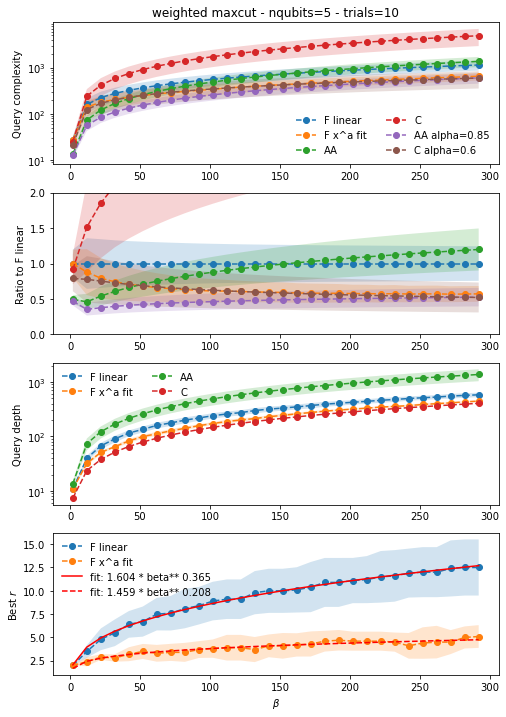

In [5]:
def plot_band(axs, x, cv, std, label=None):
    axs.plot(x, cv, 'o--',label=label)
    axs.fill_between(x, cv-std, cv+std, alpha=0.2)
    
fig, axs = plt.subplots(4, figsize=(8,12))
axs[0].set_title('weighted maxcut - nqubits=%d - trials=%d' % (nqubits, ntrials))
plot_band(axs[0], beta_range, np.mean(qref, axis=1), np.std(qref, axis=1), label='F linear')
plot_band(axs[0], beta_range, np.nanmean(qopt, axis=1), np.nanstd(qopt, axis=1), label='F x^a fit')
plot_band(axs[0], beta_range, np.mean(qampl, axis=1), np.std(qampl, axis=1), label='AA')
plot_band(axs[0], beta_range, np.mean(qc, axis=1), np.std(qc, axis=1), label='C')

plot_band(axs[0], beta_range, np.mean(qampl_alpha, axis=1), np.std(qampl_alpha, axis=1), label=f'AA alpha={alpha_ampl}')
plot_band(axs[0], beta_range, np.mean(qc_alpha, axis=1), np.std(qc_alpha, axis=1), label=f'C alpha={alpha_c}')

axs[0].set_yscale('log')
axs[0].legend(frameon=False, ncol=2)
axs[0].set_ylabel('Query complexity')

plot_band(axs[1], beta_range, np.mean(qref, axis=1)/np.mean(qref, axis=1), np.std(qref, axis=1)/np.mean(qref, axis=1))
plot_band(axs[1], beta_range, np.nanmean(qopt, axis=1)/np.mean(qref, axis=1), np.nanstd(qopt, axis=1)/np.mean(qref, axis=1))

plot_band(axs[1], beta_range, np.mean(qampl, axis=1)/np.mean(qref, axis=1), np.std(qampl, axis=1)/np.mean(qref, axis=1))
plot_band(axs[1], beta_range, np.mean(qc, axis=1)/np.mean(qref, axis=1), np.std(qc, axis=1)/np.mean(qref, axis=1))

plot_band(axs[1], beta_range, np.mean(qampl_alpha, axis=1)/np.mean(qref, axis=1), np.std(qampl_alpha, axis=1)/np.mean(qref, axis=1))
plot_band(axs[1], beta_range, np.mean(qc_alpha, axis=1)/np.mean(qref, axis=1), np.std(qc_alpha, axis=1)/np.mean(qref, axis=1))

axs[1].set_ylim([0,2])
axs[1].set_ylabel('Ratio to F linear');

axs[2].set_ylabel('Query depth');
axs[2].set_yscale('log')

plot_band(axs[2], beta_range, np.mean(qref_depth, axis=1), np.std(qref_depth, axis=1), label='F linear')
plot_band(axs[2], beta_range, np.nanmean(qopt_depth, axis=1), np.nanstd(qopt_depth, axis=1), label='F x^a fit')
plot_band(axs[2], beta_range, np.mean(qampl, axis=1), np.std(qampl, axis=1), label='AA')
plot_band(axs[2], beta_range, np.mean(qc_depth, axis=1), np.std(qc_depth, axis=1), label='C')

axs[2].legend(frameon=False, ncol=2)

axs[3].set_xlabel(r'$\beta$')
axs[3].set_ylabel('Best $r$')
plot_band(axs[3], beta_range, np.mean(bestr, axis=1), np.std(bestr, axis=1), label='F linear')
plot_band(axs[3], beta_range, np.mean(bestr_opt, axis=1), np.std(bestr_opt, axis=1), 'F x^a fit')

def func(x, a, b):
    #return a * np.log(np.abs(b) * x) + c
    return a * x ** b

popt, pcov = curve_fit(func, beta_range, np.mean(bestr, axis=1))
axs[3].plot(beta_range, func(beta_range, *popt), 'r-',
        label='fit: %5.3f * beta** %5.3f' % tuple(popt))

popt, pcov = curve_fit(func, beta_range, np.mean(bestr_opt, axis=1))
axs[3].plot(beta_range, func(beta_range, *popt), 'r--',
        label='fit: %5.3f * beta** %5.3f' % tuple(popt))
axs[3].legend(loc='upper left', frameon=False)

plt.savefig('weighted_maxcut_nqubits_%d.png' % (nqubits), bbox_inches='tight')

In [ ]:
# plot
xx = np.linspace(0,1,50)
for ii, beta in enumerate(beta_range):
    plt.figure()
    plt.title('Polynomial degree %d\nMaxCUT - qubits=%d - beta=%.1f - r=%d' % (len(initial_guess)+1,nqubits, beta, r))
    for jj in range(parameters.shape[1]):
        r = int(bestr[ii][jj])
        xr = np.array(range(1,r+1))/r      
        plt.plot(xr, xr, 'o--', color='blue', label=f'r={r}')        
        
        r = int(bestr_opt[ii][jj])
        xr = np.array(range(1,r+1))/r      
        plt.plot(xr,[myschedule(ixr, parameters[ii][jj]) for ixr in xr], 'o', color='orange', label=f'r={r}')
        plt.plot(xx,[myschedule(ixr, parameters[ii][jj]) for ixr in xx], '--', color='orange')
        print('x=',xr,'DeltaBeta=',[myschedule(ixr, parameters[ii][jj]) for ixr in xr],'\n')
        
    plt.xlabel('x = step/r')

## Example II

In [ ]:
# setup
np.random.seed(0)
ntrials = 1
beta = 200
npol = 1

def myschedule(t, params):
    return t**params[0]


nqubits_range = range(2, 10)
r_range = range(2, 45) 
alpha_c = 0.6
alpha_ampl = 0.85
qref = np.zeros(shape=(len(nqubits_range),ntrials))
qampl = np.zeros(shape=(len(nqubits_range),ntrials))
qampl_alpha = np.zeros(shape=(len(nqubits_range),ntrials))
qc = np.zeros(shape=(len(nqubits_range),ntrials))
qc_alpha = np.zeros(shape=(len(nqubits_range),ntrials))
bestr = np.zeros(shape=(len(nqubits_range), ntrials))
bestr_opt = np.zeros(shape=(len(nqubits_range), ntrials))
qopt = np.zeros(shape=(len(nqubits_range),ntrials))
parameters = np.zeros(shape=(len(nqubits_range), ntrials, npol))

    
for ii, nqubits in enumerate(nqubits_range):

    for nt in range(ntrials):
        print(f'trial={nt} nqubits={nqubits}')
        model = FragmentedQuITE(nqubits, weighted_maxcut(nqubits, norm=40.0, 
                                random_graph=True), Qu)

        qampl[ii][nt] =  model.Qampl(beta)
        qampl_alpha[ii][nt] = model.Qampl(beta, alpha=alpha_ampl)
        qc[ii][nt] = model.Q(beta)
        qc_alpha[ii][nt] = model.Q(beta, alpha=alpha_c)
        
        values = []
        for r in r_range:           
            reference = model.Qfrac_linear(r, beta)
            values.append(reference)
            print(f'trial={nt}, nqubits={nqubits}, beta={beta}, r={r}, reference={reference}')
        
        qref[ii][nt] = np.min(values)
        bestr[ii][nt] = r_range[np.argmin(values)]
        if bestr[ii][nt] == r_range[-1]:
            raise RuntimeError('Increase r_range max value.')

        values2 = []
        params2 = []
        for r in r_range:           
            initial_guess = np.array([1.0])
            result = model.minimize(myschedule, initial_parameters=initial_guess, 
                                    r=r, b=beta,
                                    method='L-BFGS-B', bounds=[[1e-3,1e3]])
            if result.success == False:
                print(result)
                continue
            values2.append(result.fun)
            params2.append(result.x)
            print(f'trial={nt}, nqubits={nqubits}, beta={beta}, r={r}, opt result={result.fun}, param={result.x} success={result.success}')
            
        qopt[ii][nt] = np.min(values2)
        bestr_opt[ii][nt] = r_range[np.argmin(values2)]
        parameters[ii][nt] = params2[np.argmin(values2)]
        if bestr_opt[ii][nt] == r_range[-1]:
            raise RuntimeError('Increase r_range max value.')

In [ ]:
def plot_band(axs, x, cv, std, label=None):
    axs.plot(x, cv, 'o--',label=label)
    axs.fill_between(x, cv-std, cv+std, alpha=0.2)
    
fig, axs = plt.subplots(3, figsize=(8,12))
axs[0].set_title('weighted maxcut - beta=%d - trials=%d' % (beta, ntrials))
plot_band(axs[0], nqubits_range, np.mean(qref, axis=1), np.std(qref, axis=1), label='F linear')
plot_band(axs[0], nqubits_range, np.nanmean(qopt, axis=1), np.nanstd(qopt, axis=1), label='F x^a fit')
plot_band(axs[0], nqubits_range, np.mean(qampl, axis=1), np.std(qampl, axis=1), label='AA')
plot_band(axs[0], nqubits_range, np.mean(qc, axis=1), np.std(qc, axis=1), label='C')

plot_band(axs[0], nqubits_range, np.mean(qampl_alpha, axis=1), np.std(qampl_alpha, axis=1), label=f'AA alpha={alpha_ampl}')
plot_band(axs[0], nqubits_range, np.mean(qc_alpha, axis=1), np.std(qc_alpha, axis=1), label=f'C alpha={alpha_c}')

axs[0].set_yscale('log')
axs[0].legend(frameon=False, ncol=2)
axs[0].set_ylabel('Query complexity')

plot_band(axs[1], nqubits_range, np.mean(qref, axis=1)/np.mean(qref, axis=1), np.std(qref, axis=1)/np.mean(qref, axis=1))
plot_band(axs[1], nqubits_range, np.nanmean(qopt, axis=1)/np.mean(qref, axis=1), np.nanstd(qopt, axis=1)/np.mean(qref, axis=1))

plot_band(axs[1], nqubits_range, np.mean(qampl, axis=1)/np.mean(qref, axis=1), np.std(qampl, axis=1)/np.mean(qref, axis=1))
plot_band(axs[1], nqubits_range, np.mean(qc, axis=1)/np.mean(qref, axis=1), np.std(qc, axis=1)/np.mean(qref, axis=1))

plot_band(axs[1], nqubits_range, np.mean(qampl_alpha, axis=1)/np.mean(qref, axis=1), np.std(qampl_alpha, axis=1)/np.mean(qref, axis=1))
plot_band(axs[1], nqubits_range, np.mean(qc_alpha, axis=1)/np.mean(qref, axis=1), np.std(qc_alpha, axis=1)/np.mean(qref, axis=1))

axs[1].set_ylim([0,2])
axs[2].set_xlabel(r'nqubits')
axs[1].set_ylabel('Ratio to F linear');

axs[2].set_ylabel('Best $r$')
plot_band(axs[2], nqubits_range, np.mean(bestr, axis=1), np.std(bestr, axis=1), label='F linear')
plot_band(axs[2], nqubits_range, np.mean(bestr_opt, axis=1), np.std(bestr_opt, axis=1), 'F x^a fit')

plt.savefig('weighted_maxcut_beta_%d.png' % (beta), bbox_inches='tight')

In [ ]:
# plot
xx = np.linspace(0,1,50)
for ii, nqubits in enumerate(nqubits_range):
    plt.figure()
    plt.title('Polynomial degree %d\nMaxCUT - qubits=%d - beta=%.1f - r=%d' % (len(initial_guess)+1,nqubits, beta, r))
    for jj in range(parameters.shape[1]):
        r = int(bestr[ii][jj])
        xr = np.array(range(1,r+1))/r      
        plt.plot(xr, xr, 'o--', color='blue', label=f'r={r}')        
        
        r = int(bestr_opt[ii][jj])
        xr = np.array(range(1,r+1))/r      
        plt.plot(xr,[myschedule(ixr, parameters[ii][jj]) for ixr in xr], 'o', color='orange', label=f'r={r}')
        plt.plot(xx,[myschedule(ixr, parameters[ii][jj]) for ixr in xx], '--', color='orange')
        print('x=',xr,'DeltaBeta=',[myschedule(ixr, parameters[ii][jj]) for ixr in xr],'\n')
        
    plt.xlabel('x = step/r')